# Modelado de Tópicos en Tweets: Comparando LDA y BERTopic

## Introducción

En esta sesión exploraremos dos enfoques diferentes para el modelado de tópicos:

1. **LDA (Latent Dirichlet Allocation)**: Método tradicional basado en estadística bayesiana
2. **BERTopic**: Método moderno que utiliza embeddings de transformers y clustering

Analizaremos tweets de políticos colombianos para identificar los temas principales de discusión y compararemos ambos enfoques.


## 1. Configuración e instalación

In [ ]:
# Fase 1: Librerías fundamentales
!pip install pandas numpy matplotlib seaborn scikit-learn

# Fase 2: Librerías especializadas
!pip install gensim wordcloud

# Fase 3: Ecosistema BERTopic (importante: instalar en orden específico)
!pip install sentence-transformers
!pip install umap-learn
!pip install hdbscan
!pip install bertopic

# Opcional pero recomendado: spaCy para mejor procesamiento
!pip install spacy
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 150.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Importaciones
import pandas as pd
import numpy as np
import re
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Procesamiento de texto y NLP
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score

# BERTopic y dependencias
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN

In [ ]:
# Configuración de visualizaciones
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

print("Librerías importadas correctamente")
print("Cargando modelo de spaCy para español...")
nlp = spacy.load('es_core_news_sm')

Librerías importadas correctamente
Cargando modelo de spaCy para español...


## 2. Carga y preprocesamiento de datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/Clases/NLP para ciencias sociales/99. Datos/tweets_muestra_estratificada.csv'
df = pd.read_csv(file_path)
print(df.head())

                         id       politico                       fecha_raw  \
0  677f1f14782ccacddc4e6e35  Gustavo Petro  Tue Mar 24 19:44:38 +0000 2020   
1  677f1f13782ccacddc4e6a20  Gustavo Petro  Thu Mar 26 13:29:14 +0000 2020   
2  677f1f15782ccacddc4e72c7  Gustavo Petro  Wed Mar 11 00:17:32 +0000 2020   
3  677f1f14782ccacddc4e6e26  Gustavo Petro  Tue Mar 24 21:19:29 +0000 2020   
4  677f1f13782ccacddc4e672d  Gustavo Petro  Fri Mar 27 12:25:47 +0000 2020   

                                               texto  \
0  Existe en nuestra sociedad burbujas informativ...   
1  La evaluación del presidente de la asociación ...   
2  Solo dejando de emitir CO2 en todo el mundo se...   
3  Solo he hablado una vez con el presidente para...   
4  El confinamiento se prolongará al menos dos me...   

                       fecha     año  mes  año_mes  
0  2020-03-24 19:44:38+00:00  2020.0  3.0  2020-03  
1  2020-03-26 13:29:14+00:00  2020.0  3.0  2020-03  
2  2020-03-11 00:17:32+00:00  2020.

In [ ]:
# Preparar datos temporales si no existen o si la columna 'fecha' no es datetime
if 'fecha' not in df.columns:
    print("La columna 'fecha' no existe. Creando columna temporal...")
    # Create a placeholder if 'fecha' doesn't exist
    df['fecha'] = pd.date_range('2019-01-01', periods=len(df), freq='D')
else:
    # Ensure 'fecha' is datetime, coercing errors to NaT
    print("Convirtiendo la columna 'fecha' a datetime...")
    df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')

# Drop rows where fecha is NaT after coercion, as they cannot be used for temporal analysis
df.dropna(subset=['fecha'], inplace=True)

# Now extract temporal components from the datetime column
df['año'] = df['fecha'].dt.year
df['mes'] = df['fecha'].dt.month
df['trimestre'] = df['fecha'].dt.quarter
df['año_trimestre'] = df['año'].astype(str) + '-Q' + df['trimestre'].astype(str)

print("Columnas temporales creadas o actualizadas.")

Convirtiendo la columna 'fecha' a datetime...
Columnas temporales creadas o actualizadas.


# 3. Preprocesamiento Avanzado de Texto

El preprocesamiento es crucial para el éxito del modelado de tópicos. Utilizaremos spaCy para un procesamiento más sofisticado que incluye lematización y reconocimiento de entidades.


In [ ]:
def obtener_stopwords_espanol():
    """
    Obtener stopwords en español desde spaCy.
    """
    # Usar stopwords de spaCy
    stopwords = nlp.Defaults.stop_words
    print(f"Stopwords de spaCy cargadas: {len(stopwords)} palabras")
    return stopwords

def limpiar_texto_basico(texto):
    """
    Limpieza básica del texto antes del procesamiento con spaCy.
    Remueve elementos específicos de redes sociales y normaliza el formato.
    """
    if pd.isna(texto):
        return ""

    # Convertir a minúsculas
    texto = texto.lower()

    # Remover elementos específicos de Twitter
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)  # URLs
    texto = re.sub(r'@\w+', '', texto)  # Menciones (@usuario)
    texto = re.sub(r'#\w+', '', texto)  # Hashtags
    texto = re.sub(r'rt\s+', '', texto)  # Retweets

    # Limpiar caracteres especiales pero preservar estructura
    texto = re.sub(r'[^\w\s\.\!\?\,\;\:]', ' ', texto)  # Preservar puntuación básica
    texto = re.sub(r'\d+', '', texto)  # Remover números
    texto = re.sub(r'\s+', ' ', texto)  # Normalizar espacios

    return texto.strip()

def procesar_texto_avanzado(texto, stopwords):
    """
    Procesamiento avanzado usando spaCy para lematización y filtrado inteligente.
    """
    if not texto:
        return ""

    # Procesamiento con spaCy
    doc = nlp(texto)

    tokens_procesados = []
    for token in doc:
        # Filtros para tokens válidos
        if (not token.is_stop and           # No es stopword
            not token.is_punct and          # No es puntuación
            not token.is_space and          # No es espacio
            token.is_alpha and              # Solo letras
            len(token.text) > 2 and         # Longitud mínima
            token.lemma_ not in stopwords): # Lemma no es stopword

            tokens_procesados.append(token.lemma_)

    return ' '.join(tokens_procesados)

In [ ]:
# Ejecutar preprocesamiento
print("=== INICIANDO PREPROCESAMIENTO ===")
print("Fase 1: Limpieza básica...")

# Obtener stopwords
stopwords_es = obtener_stopwords_espanol()

# Aplicar limpieza básica
df['texto_limpio'] = df['texto'].apply(limpiar_texto_basico)

print("Fase 2: Procesamiento avanzado...")
# Aplicar procesamiento avanzado
df['texto_procesado'] = df['texto_limpio'].apply(
    lambda x: procesar_texto_avanzado(x, stopwords_es)
)

# Filtrar textos demasiado cortos después del procesamiento
longitud_minima = 15  # caracteres mínimos después del procesamiento
df = df[df['texto_procesado'].str.len() >= longitud_minima].copy()

print(f"Tweets después del preprocesamiento: {len(df):,}")
print(f"Tweets filtrados por longitud: {len(df):,}")

# Estadísticas del texto procesado
df['longitud_procesado'] = df['texto_procesado'].str.len()
print(f"Longitud promedio procesada: {df['longitud_procesado'].mean():.1f} caracteres")

# Mostrar ejemplos del preprocesamiento
print("\n=== EJEMPLOS DE PREPROCESAMIENTO ===")
ejemplos = df.head(3)
for i, ejemplo in ejemplos.iterrows():
    print(f"\nEjemplo {i+1}:")
    print(f"Original: {ejemplo['texto'][:150]}...")
    print(f"Procesado: {ejemplo['texto_procesado'][:150]}...")
    print("-" * 60)

# Análisis de vocabulario
vocabulario_completo = ' '.join(df['texto_procesado']).split()
conteo_palabras = Counter(vocabulario_completo)
print(f"\nVocabulario total: {len(conteo_palabras):,} palabras únicas")
print("Palabras más frecuentes:")
for palabra, freq in conteo_palabras.most_common(10):
    print(f"  {palabra}: {freq:,}")

=== INICIANDO PREPROCESAMIENTO ===
Fase 1: Limpieza básica...
Stopwords de spaCy cargadas: 521 palabras
Fase 2: Procesamiento avanzado...
Tweets después del preprocesamiento: 3,904
Tweets filtrados por longitud: 3,904
Longitud promedio procesada: 127.5 caracteres

=== EJEMPLOS DE PREPROCESAMIENTO ===

Ejemplo 1:
Original: Existe en nuestra sociedad burbujas informativas. Mucha gente aún no sabe que pasa en el mundo ni la gravedad del virus

Por la escasez de recursos ha...
Procesado: sociedad burbuja informativo gente pasar mundo gravedad virus escasez recurso comunicación distracción único información...
------------------------------------------------------------

Ejemplo 2:
Original: La evaluación del presidente de la asociación de hospitales de Francia dice:

Como no podemos hacer hospitales en 15 días es necesario

1. Proteger al...
Procesado: evaluación presidente asociación hospital francia hospital necesario proteger máximo personal salud utilizar hospital clínica abandonado...

# 4. Modelado de Tópicos con LDA

LDA asume que cada documento es una mezcla de tópicos y cada tópico es una mezcla de palabras. Este modelo probabilístico nos permite interpretar los tópicos de manera intuitiva.

## 4.1 Preparación de datos para LDA


In [ ]:
print("=== PREPARACIÓN DE DATOS PARA LDA ===")

# Configurar vectorizador TF-IDF con parámetros optimizados
# min_df: palabra debe aparecer en al menos X documentos (reduce ruido)
# max_df: palabra no debe aparecer en más del X% de documentos (evita palabras muy comunes)
# max_features: limita el vocabulario a las palabras más frecuentes

vectorizer_tfidf = TfidfVectorizer(
    max_features=1000,      # Vocabulario de 1000 términos más relevantes
    min_df=5,               # Palabra debe aparecer en al menos 5 documentos
    max_df=0.7,             # Palabra no debe aparecer en más del 70% de documentos
    ngram_range=(1, 2),     # Incluir unigramas y bigramas
    sublinear_tf=True       # Aplicar escalado logarítmico a tf
)

# Crear matriz TF-IDF
print("Creando matriz TF-IDF...")
tfidf_matrix = vectorizer_tfidf.fit_transform(df['texto_procesado'])
feature_names_tfidf = vectorizer_tfidf.get_feature_names_out()

print(f"Matriz TF-IDF creada: {tfidf_matrix.shape}")
print(f"Vocabulario final: {len(feature_names_tfidf):,} términos")

# Mostrar términos más relevantes (mayor IDF)
idf_scores = vectorizer_tfidf.idf_
feature_idf = list(zip(feature_names_tfidf, idf_scores))
feature_idf.sort(key=lambda x: x[1], reverse=True)

print("\nTérminos más discriminativos (mayor IDF):")
for term, idf in feature_idf[:10]:
    print(f"  {term}: {idf:.3f}")

print("\nTérminos más comunes (menor IDF):")
for term, idf in feature_idf[-10:]:
    print(f"  {term}: {idf:.3f}")

=== PREPARACIÓN DE DATOS PARA LDA ===
Creando matriz TF-IDF...
Matriz TF-IDF creada: (3904, 1000)
Vocabulario final: 1,000 términos

Términos más discriminativos (mayor IDF):
  usd onza: 7.191
  cne: 6.967
  minero: 6.872
  adicional: 6.785
  eléctrico: 6.785
  universidad público: 6.785
  argumento: 6.705
  arte: 6.705
  bus: 6.705
  candidata: 6.705

Términos más comunes (menor IDF):
  duque: 4.002
  bogotá: 3.967
  millón: 3.923
  social: 3.828
  colombiano: 3.802
  año: 3.798
  gobierno: 3.537
  él: 3.365
  país: 3.202
  colombia: 2.880


## 4.2 Entrenamiento y optimización de LDA

In [ ]:
print("=== ENTRENAMIENTO DEL MODELO LDA ===")

# Configurar modelo LDA con parámetros balanceados
# n_components: número de tópicos (parámetro crítico)
# doc_topic_prior (alpha): controla dispersión de tópicos por documento
# topic_word_prior (beta): controla dispersión de palabras por tópico

n_topics_lda = 8

lda_model = LatentDirichletAllocation(
    n_components=n_topics_lda,
    doc_topic_prior=0.1,        # Alpha bajo = documentos más especializados
    topic_word_prior=0.01,      # Beta bajo = tópicos más específicos
    random_state=42,
    max_iter=20,                # Suficientes iteraciones para convergencia
    learning_method='batch',    # Más estable que 'online'
    n_jobs=-1,                  # Usar todos los cores disponibles
    verbose=1
)

print(f"Entrenando LDA con {n_topics_lda} tópicos...")
lda_model.fit(tfidf_matrix)

# Evaluar calidad del modelo
log_likelihood = lda_model.score(tfidf_matrix)
perplexity = lda_model.perplexity(tfidf_matrix)

print(f"\nMétricas del modelo:")
print(f"  Log-likelihood: {log_likelihood:.2f}")
print(f"  Perplejidad: {perplexity:.2f}")
print("  (Menor perplejidad indica mejor ajuste)")

=== ENTRENAMIENTO DEL MODELO LDA ===
Entrenando LDA con 8 tópicos...
iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20
iteration: 5 of max_iter: 20
iteration: 6 of max_iter: 20
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20
iteration: 15 of max_iter: 20
iteration: 16 of max_iter: 20
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20

Métricas del modelo:
  Log-likelihood: -93838.89
  Perplejidad: 5172.50
  (Menor perplejidad indica mejor ajuste)


## 4.3 Análisis e interpretación de tópicos LDA

In [ ]:
def interpretar_topicos_lda(modelo, vectorizador, n_palabras=10):
    """
    Extrae e interpreta los tópicos del modelo LDA mostrando
    las palabras más importantes y sus pesos.
    """
    feature_names = vectorizador.get_feature_names_out()

    print("=== TÓPICOS IDENTIFICADOS POR LDA ===")
    topicos_interpretados = {}

    for topic_idx, topic_dist in enumerate(modelo.components_):
        # Obtener palabras más importantes del tópico
        top_words_idx = topic_dist.argsort()[-n_palabras:][::-1]
        top_words = [(feature_names[i], topic_dist[i]) for i in top_words_idx]

        topicos_interpretados[topic_idx] = top_words

        print(f"\nTópico {topic_idx + 1}:")
        # Mostrar palabras con sus pesos
        palabras_principales = []
        for palabra, peso in top_words:
            print(f"  {palabra}: {peso:.4f}")
            palabras_principales.append(palabra)

        # Sugerir interpretación temática
        tema_sugerido = ", ".join(palabras_principales[:5])
        print(f"  → Tema sugerido: {tema_sugerido}")

    return topicos_interpretados

In [ ]:
# Interpretar tópicos
topicos_lda = interpretar_topicos_lda(lda_model, vectorizer_tfidf)

=== TÓPICOS IDENTIFICADOS POR LDA ===

Tópico 1:
  salud: 19.9702
  climático: 15.3088
  cambio: 14.8867
  san: 13.2946
  vida: 12.6699
  sistema: 11.9150
  mundo: 11.4960
  él: 10.8708
  gente: 10.7581
  hospital: 10.3661
  → Tema sugerido: salud, climático, cambio, san, vida

Tópico 2:
  sociedad: 12.9158
  él: 12.4696
  fuerza: 12.0368
  policía: 11.5785
  venezuela: 11.2659
  terminar: 10.6076
  terrorista: 10.2213
  colombia: 10.1313
  justicia: 9.9114
  violencia: 9.8122
  → Tema sugerido: sociedad, él, fuerza, policía, venezuela

Tópico 3:
  país: 29.0384
  colombia: 19.9737
  gobierno: 17.6922
  región: 16.3711
  reunión: 16.0679
  desarrollo: 15.7604
  seguridad: 15.6095
  empleo: 15.3544
  trabajo: 14.8485
  trabajar: 14.7131
  → Tema sugerido: país, colombia, gobierno, región, reunión

Tópico 4:
  pacto: 17.6519
  favor: 16.1254
  vía: 15.3300
  histórico: 15.2245
  pacto histórico: 13.5201
  candidato: 13.1822
  uribista: 12.2238
  senador: 11.8592
  lista: 11.7042
  operac

## 4.4 Asignación de tópicos a documentos

In [ ]:
print("=== ASIGNACIÓN DE TÓPICOS A DOCUMENTOS ===")

# Obtener distribución de tópicos para cada documento
# Cada fila representa un documento, cada columna un tópico
doc_topic_distributions = lda_model.transform(tfidf_matrix)

# Asignar tópico dominante (mayor probabilidad) a cada tweet
df['topico_lda'] = doc_topic_distributions.argmax(axis=1)
df['probabilidad_lda'] = doc_topic_distributions.max(axis=1)

# Estadísticas de asignación
print("Distribución de documentos por tópico:")
distribucion_topicos = df['topico_lda'].value_counts().sort_index()
for topico, cantidad in distribucion_topicos.items():
    porcentaje = (cantidad / len(df)) * 100
    print(f"  Tópico {topico + 1}: {cantidad:,} tweets ({porcentaje:.1f}%)")

print(f"\nProbabilidad promedio de asignación: {df['probabilidad_lda'].mean():.3f}")
print(f"Rango de probabilidades: {df['probabilidad_lda'].min():.3f} - {df['probabilidad_lda'].max():.3f}")

# Identificar documentos con asignaciones ambiguas (baja probabilidad)
umbral_ambiguedad = 0.3
documentos_ambiguos = df[df['probabilidad_lda'] < umbral_ambiguedad]

=== ASIGNACIÓN DE TÓPICOS A DOCUMENTOS ===
Distribución de documentos por tópico:
  Tópico 1: 396 tweets (10.1%)
  Tópico 2: 367 tweets (9.4%)
  Tópico 3: 587 tweets (15.0%)
  Tópico 4: 447 tweets (11.4%)
  Tópico 5: 591 tweets (15.1%)
  Tópico 6: 471 tweets (12.1%)
  Tópico 7: 413 tweets (10.6%)
  Tópico 8: 632 tweets (16.2%)

Probabilidad promedio de asignación: 0.608
Rango de probabilidades: 0.125 - 0.871


## 4.5 Ejemplos representativos por tópico

In [ ]:
def mostrar_ejemplos_por_topico(dataframe, modelo_nombre="LDA", n_ejemplos=2):
    """
    Muestra los ejemplos más representativos de cada tópico
    basado en la probabilidad de asignación.
    """
    print(f"=== EJEMPLOS REPRESENTATIVOS POR TÓPICO ({modelo_nombre}) ===")

    columna_topico = f'topico_{modelo_nombre.lower()}'
    columna_prob = f'probabilidad_{modelo_nombre.lower()}'

    for topico in sorted(dataframe[columna_topico].unique()):
        print(f"\n{'='*20} TÓPICO {topico + 1} {'='*20}")

        # Obtener tweets más representativos del tópico
        tweets_topico = dataframe[dataframe[columna_topico] == topico]
        ejemplos = tweets_topico.nlargest(n_ejemplos, columna_prob)

        for i, (_, tweet) in enumerate(ejemplos.iterrows(), 1):
            print(f"\nEjemplo {i}:")
            print(f"  Probabilidad: {tweet[columna_prob]:.3f}")
            print(f"  Político: {tweet['politico']}")
            print(f"  Fecha: {tweet['fecha']} ({tweet['año_trimestre']})")
            print(f"  Texto: {tweet['texto'][:250]}...")
            if len(tweet['texto']) > 250:
                print("    [...]")

        print("-" * 60)

In [ ]:
# Mostrar ejemplos
mostrar_ejemplos_por_topico(df, "LDA")

=== EJEMPLOS REPRESENTATIVOS POR TÓPICO (LDA) ===

==================== TÓPICO 1 ====================

Ejemplo 1:
  Probabilidad: 0.856
  Político: Gustavo Petro
  Fecha: 2020-03-29 14:51:04+00:00 (2020-Q1)
  Texto: Daniel ha llegado como conclusión a defender uno de las programas centrales de la Colombia Humana:

Superar la ley 100 y construir un sistema de salud pública preventivo con amplio fortalecimiento de la red pública hospitalaria....

Ejemplo 2:
  Probabilidad: 0.850
  Político: Gustavo Petro
  Fecha: 2019-09-23 12:29:05+00:00 (2019-Q3)
  Texto: La actuación sobre la crisis climática sea para disminuir la emisión de gases efecto invernadero, sea para adaptar los territorios y su población a la emergencia climática es todo un programa político que Colombia Humana debe adelantar en todo el paí...
    [...]
------------------------------------------------------------

==================== TÓPICO 2 ====================

Ejemplo 1:
  Probabilidad: 0.839
  Político: Gustavo Petro
 

# 5. Modelado de Tópicos con BERTopic

BERTopic representa el estado del arte en modelado de tópicos, combinando embeddings contextuales de transformers con técnicas modernas de clustering para crear representaciones semánticamente más ricas.


## 5.1 Configuración avanzada de BERTopic

In [ ]:
print("=== CONFIGURACIÓN DE BERTOPIC ===")

# Seleccionar modelo de embeddings multilingüe optimizado para español
# Este modelo fue entrenado específicamente para tareas multilingües
print("Configurando modelo de embeddings...")
embedding_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
print("Modelo de embeddings cargado: paraphrase-multilingual-MiniLM-L12-v2")

=== CONFIGURACIÓN DE BERTOPIC ===
Configurando modelo de embeddings...
Modelo de embeddings cargado: paraphrase-multilingual-MiniLM-L12-v2


In [ ]:
# Configurar UMAP para reducción de dimensionalidad
# UMAP preserva tanto la estructura local como global de los datos
print("Configurando UMAP...")
umap_model = UMAP(
    n_neighbors=15,        # Número de vecinos (balance local/global)
    n_components=5,        # Dimensiones del espacio reducido
    min_dist=0.0,          # Distancia mínima entre puntos (más compacto)
    metric='cosine',       # Métrica de distancia (ideal para texto)
    random_state=42
)

# Configurar HDBSCAN para clustering
# HDBSCAN puede encontrar clusters de densidad variable y detectar ruido
print("Configurando HDBSCAN...")
hdbscan_model = HDBSCAN(
    min_cluster_size=20,           # Tamaño mínimo de cluster (ajustar según dataset)
    min_samples=5,                 # Muestras mínimas para considerar punto core
    metric='euclidean',            # Métrica de distancia para clustering
    cluster_selection_method='eom', # Excess of Mass (más estable)
    prediction_data=True           # Permitir predicciones en nuevos datos
)

# Configurar vectorizador para representación de tópicos
# Usamos CountVectorizer para BERTopic (no TF-IDF)
print("Configurando vectorizador...")
vectorizer_bertopic = CountVectorizer(
    min_df=5,              # Palabra debe aparecer en al menos 5 documentos
    max_df=0.8,            # Palabra no debe aparecer en más del 80%
    stop_words=None,       # Ya preprocesamos el texto
    ngram_range=(1, 2)     # Unigramas y bigramas
)

# Crear modelo BERTopic integrado
print("Integrando componentes en BERTopic...")
bertopic_model = BERTopic(
    # Modelos principales
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_bertopic,

    # Configuración de representación
    nr_topics=None,                    # Auto-detectar número óptimo
    low_memory=False,                  # Usar más memoria para mejor rendimiento
    calculate_probabilities=True,      # Calcular probabilidades (más lento pero útil)

    # Configuración de logging
    verbose=True
)

print("BERTopic configurado exitosamente")

Configurando UMAP...
Configurando HDBSCAN...
Configurando vectorizador...
Integrando componentes en BERTopic...
BERTopic configurado exitosamente


## 5.2 Entrenamiento de BERTopic

In [ ]:
print("=== ENTRENAMIENTO DE BERTOPIC ===")
print("Iniciando entrenamiento (esto puede tomar varios minutos)...")
print("Progreso: Generando embeddings → Reduciendo dimensionalidad → Clustering → Creando representaciones")

# Entrenar modelo
# fit_transform devuelve asignaciones de tópicos y probabilidades
topics_bertopic, probabilities_bertopic = bertopic_model.fit_transform(df['texto_procesado'].tolist())

print("Entrenamiento completado")

2025-06-04 20:10:16,081 - BERTopic - Embedding - Transforming documents to embeddings.


=== ENTRENAMIENTO DE BERTOPIC ===
Iniciando entrenamiento (esto puede tomar varios minutos)...
Progreso: Generando embeddings → Reduciendo dimensionalidad → Clustering → Creando representaciones


Batches:   0%|          | 0/122 [00:00<?, ?it/s]

2025-06-04 20:12:57,322 - BERTopic - Embedding - Completed ✓
2025-06-04 20:12:57,326 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-04 20:13:51,910 - BERTopic - Dimensionality - Completed ✓
2025-06-04 20:13:51,911 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-04 20:13:52,520 - BERTopic - Cluster - Completed ✓
2025-06-04 20:13:52,528 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-04 20:13:52,719 - BERTopic - Representation - Completed ✓


Entrenamiento completado

=== RESULTADOS DEL ENTRENAMIENTO ===
Número de tópicos encontrados: 31
Documentos outliers (sin tópico claro): 1,058 (27.1%)
Documentos con tópico asignado: 2,846 (72.9%)

Información de tópicos encontrados:
   Topic  Count                                               Name
0     -1   1058                        -1_usd_social_congreso_vida
1      0    880       0_colombia_colombiano_colombia humano_humano
2      1    486                   1_uribir_gracias_acabar_medellín
3      2     94             2_salud_hospital_sistema_sistema salud
4      3     92                3_terrorista_matar_terrorismo_joven
5      4     88                  4_deuda_billón_tributario_crédito
6      5     87              5_droga_consumo_narcotráfico_tonelada
7      6     83                    6_paz_violencia_democracia_odio
8      7     80                  7_alcalde_gobernador_ciudad_local
9      8     73  8_solidaridad_familia_solidaridad familia_víctima
Silhouette Score: 0.029 (rang

In [ ]:
# Analizar resultados del entrenamiento
print("\n=== RESULTADOS DEL ENTRENAMIENTO ===")
topic_info = bertopic_model.get_topic_info()

# BERTopic asigna -1 a documentos que no se ajustan bien a ningún cluster (outliers)
n_topics_found = len(topic_info) - 1  # -1 porque el tópico -1 son outliers
n_outliers = sum(1 for t in topics_bertopic if t == -1)

print(f"Número de tópicos encontrados: {n_topics_found}")
print(f"Documentos outliers (sin tópico claro): {n_outliers:,} ({n_outliers/len(df)*100:.1f}%)")
print(f"Documentos con tópico asignado: {len(df) - n_outliers:,} ({(len(df) - n_outliers)/len(df)*100:.1f}%)")


=== RESULTADOS DEL ENTRENAMIENTO ===
Número de tópicos encontrados: 31
Documentos outliers (sin tópico claro): 1,058 (27.1%)
Documentos con tópico asignado: 2,846 (72.9%)


In [ ]:
# Mostrar información general de tópicos
print("\nInformación de tópicos encontrados:")
print(topic_info[['Topic', 'Count', 'Name']].head(10))


Información de tópicos encontrados:
   Topic  Count                                               Name
0     -1   1058                        -1_usd_social_congreso_vida
1      0    880       0_colombia_colombiano_colombia humano_humano
2      1    486                   1_uribir_gracias_acabar_medellín
3      2     94             2_salud_hospital_sistema_sistema salud
4      3     92                3_terrorista_matar_terrorismo_joven
5      4     88                  4_deuda_billón_tributario_crédito
6      5     87              5_droga_consumo_narcotráfico_tonelada
7      6     83                    6_paz_violencia_democracia_odio
8      7     80                  7_alcalde_gobernador_ciudad_local
9      8     73  8_solidaridad_familia_solidaridad familia_víctima


In [ ]:
# Evaluar calidad de la separación de clusters
if n_outliers < len(df):  # Solo si hay clusters válidos
    # Calcular embeddings para evaluación
    embeddings = embedding_model.encode(df['texto_procesado'].tolist())

    # Filtrar outliers para cálculo de silhouette
    valid_topics = [t for t in topics_bertopic if t != -1]
    valid_embeddings = embeddings[[i for i, t in enumerate(topics_bertopic) if t != -1]]

    if len(set(valid_topics)) > 1:  # Necesitamos al menos 2 clusters
        silhouette_avg = silhouette_score(valid_embeddings, valid_topics)
        print(f"Silhouette Score: {silhouette_avg:.3f} (rango: -1 a 1, mayor es mejor)")

Silhouette Score: 0.029 (rango: -1 a 1, mayor es mejor)


## 5.3 Análisis detallado de tópicos BERTopic

In [ ]:
def analizar_topicos_bertopic(modelo, info_topicos, n_palabras=10):
    """
    Analiza y presenta los tópicos encontrados por BERTopic
    con sus palabras clave y puntuaciones de relevancia.
    """
    print("=== ANÁLISIS DETALLADO DE TÓPICOS BERTOPIC ===")

    # Excluir tópico -1 (outliers) del análisis principal
    topicos_validos = info_topicos[info_topicos['Topic'] != -1]

    for _, row in topicos_validos.head(10).iterrows():  # Mostrar top 10 tópicos
        topic_id = row['Topic']
        topic_size = row['Count']

        print(f"\n{'='*15} TÓPICO {topic_id} ({'='*15}")
        print(f"Número de documentos: {topic_size:,}")
        print(f"Porcentaje del corpus: {topic_size/len(df)*100:.1f}%")

        # Obtener palabras del tópico con sus puntuaciones
        topic_words = modelo.get_topic(topic_id)

        print("Palabras clave (con relevancia):")
        palabras_relevantes = []
        for palabra, relevancia in topic_words[:n_palabras]:
            print(f"  {palabra}: {relevancia:.4f}")
            palabras_relevantes.append(palabra)

        # Crear descriptor temático
        descriptor = " + ".join(palabras_relevantes[:5])
        print(f"Descriptor temático: {descriptor}")

        print("-" * 50)

    return topicos_validos

In [ ]:
topicos_bertopic_info = analizar_topicos_bertopic(bertopic_model, topic_info)

=== ANÁLISIS DETALLADO DE TÓPICOS BERTOPIC ===

=============== TÓPICO 0 (===============
Número de documentos: 880
Porcentaje del corpus: 22.5%
Palabras clave (con relevancia):
  colombia: 0.0596
  colombiano: 0.0392
  colombia humano: 0.0240
  humano: 0.0215
  paz: 0.0161
  pueblo: 0.0142
  presidente: 0.0139
  social: 0.0133
  democracia: 0.0125
  historia: 0.0122
Descriptor temático: colombia + colombiano + colombia humano + humano + paz
--------------------------------------------------

=============== TÓPICO 1 (===============
Número de documentos: 486
Porcentaje del corpus: 12.4%
Palabras clave (con relevancia):
  uribir: 0.0238
  gracias: 0.0203
  acabar: 0.0187
  medellín: 0.0170
  carlos: 0.0157
  hora: 0.0150
  santa: 0.0146
  querer: 0.0144
  petro: 0.0137
  casa: 0.0134
Descriptor temático: uribir + gracias + acabar + medellín + carlos
--------------------------------------------------

=============== TÓPICO 2 (===============
Número de documentos: 94
Porcentaje del corp


## 5.4 Asignación y análisis de probabilidades BERTopic

In [ ]:
print("=== ASIGNACIÓN DE TÓPICOS BERTOPIC ===")

# Asignar resultados al dataframe
df['topico_bertopic'] = topics_bertopic

# Manejar las probabilidades de BERTopic
if probabilities_bertopic is not None:
    # Verificar la forma de las probabilidades
    print(f"Forma de probabilidades BERTopic: {np.array(probabilities_bertopic).shape}")

    if len(np.array(probabilities_bertopic).shape) == 2:
        # Si es una matriz, tomar la probabilidad máxima por documento
        df['probabilidad_bertopic'] = np.max(probabilities_bertopic, axis=1)
        print("Probabilidades extraídas como máximo por documento")
    elif len(np.array(probabilities_bertopic).shape) == 1:
        # Si es un vector, usar directamente
        df['probabilidad_bertopic'] = probabilities_bertopic
        print("Probabilidades asignadas directamente")
    else:
        print("Forma de probabilidades no reconocida, asignando valores por defecto")
        df['probabilidad_bertopic'] = 0.0
else:
    print("No se calcularon probabilidades, asignando valores por defecto")
    df['probabilidad_bertopic'] = 0.0

# Analizar distribución de tópicos
print("Distribución de documentos por tópico:")
distribucion_bertopic = df['topico_bertopic'].value_counts().sort_index()

for topico, cantidad in distribucion_bertopic.items():
    porcentaje = (cantidad / len(df)) * 100
    if topico == -1:
        print(f"  Outliers: {cantidad:,} tweets ({porcentaje:.1f}%)")
    else:
        print(f"  Tópico {topico}: {cantidad:,} tweets ({porcentaje:.1f}%)")

# Analizar calidad de las asignaciones solo si hay probabilidades válidas
documentos_con_topico = df[df['topico_bertopic'] != -1]
if len(documentos_con_topico) > 0 and df['probabilidad_bertopic'].max() > 0:
    prob_validas = documentos_con_topico['probabilidad_bertopic']
    print(f"\nEstadísticas de probabilidad (excluyendo outliers):")
    print(f"  Probabilidad promedio: {prob_validas.mean():.3f}")
    print(f"  Mediana: {prob_validas.median():.3f}")
    print(f"  Rango: {prob_validas.min():.3f} - {prob_validas.max():.3f}")

    # Identificar asignaciones con alta vs baja confianza
    if prob_validas.std() > 0:  # Solo si hay variabilidad
        alta_confianza = prob_validas.quantile(0.75)
        baja_confianza = prob_validas.quantile(0.25)

        print(f"  Alta confianza (>Q3={alta_confianza:.3f}): {(prob_validas > alta_confianza).sum():,} documentos")
        print(f"  Baja confianza (<Q1={baja_confianza:.3f}): {(prob_validas < baja_confianza).sum():,} documentos")
else:
    print(f"\nProbabilidades no disponibles o no válidas para análisis detallado")

=== ASIGNACIÓN DE TÓPICOS BERTOPIC ===
Forma de probabilidades BERTopic: (3904, 31)
Probabilidades extraídas como máximo por documento
Distribución de documentos por tópico:
  Outliers: 1,058 tweets (27.1%)
  Tópico 0: 880 tweets (22.5%)
  Tópico 1: 486 tweets (12.4%)
  Tópico 2: 94 tweets (2.4%)
  Tópico 3: 92 tweets (2.4%)
  Tópico 4: 88 tweets (2.3%)
  Tópico 5: 87 tweets (2.2%)
  Tópico 6: 83 tweets (2.1%)
  Tópico 7: 80 tweets (2.0%)
  Tópico 8: 73 tweets (1.9%)
  Tópico 9: 62 tweets (1.6%)
  Tópico 10: 59 tweets (1.5%)
  Tópico 11: 58 tweets (1.5%)
  Tópico 12: 55 tweets (1.4%)
  Tópico 13: 51 tweets (1.3%)
  Tópico 14: 51 tweets (1.3%)
  Tópico 15: 48 tweets (1.2%)
  Tópico 16: 48 tweets (1.2%)
  Tópico 17: 45 tweets (1.2%)
  Tópico 18: 44 tweets (1.1%)
  Tópico 19: 41 tweets (1.1%)
  Tópico 20: 38 tweets (1.0%)
  Tópico 21: 35 tweets (0.9%)
  Tópico 22: 34 tweets (0.9%)
  Tópico 23: 32 tweets (0.8%)
  Tópico 24: 29 tweets (0.7%)
  Tópico 25: 29 tweets (0.7%)
  Tópico 26: 26 twe

In [ ]:
# Mostrar ejemplos por tópico BERTopic
mostrar_ejemplos_por_topico(df, "BERTOPIC")

=== EJEMPLOS REPRESENTATIVOS POR TÓPICO (BERTOPIC) ===

==================== TÓPICO 0 ====================

Ejemplo 1:
  Probabilidad: 0.327
  Político: Iván Duque
  Fecha: 2022-03-31 01:00:02+00:00 (2022-Q1)
  Texto: Somos el Gobierno que ha apoyado a las entidades territoriales y una de nuestras principales aliadas, las JAC; sacamos adelante la Ley de Acción Comunal, fortalecimos la escuela de líderes y, si le agregamos los logros en Equidad, validamos que la ju...
    [...]

Ejemplo 2:
  Probabilidad: 0.314
  Político: Álvaro Uribe
  Fecha: 2021-11-14 00:42:02+00:00 (2021-Q4)
  Texto: Para hacer prevalecer los principios del partido y ser autocríticos con las acciones, tenemos que señalar lo bueno y reconocer lo que falta. https://t.co/fbgBhfLulq...
------------------------------------------------------------

==================== TÓPICO 1 ====================

Ejemplo 1:
  Probabilidad: 1.000
  Político: Gustavo Petro
  Fecha: 2019-11-28 13:27:00+00:00 (2019-Q4)
  Texto: Esto es me

# 6. Comparación Sistemática de Métodos

La comparación entre LDA y BERTopic nos permite entender las fortalezas y limitaciones de cada aproximación en el contexto específico del análisis de tweets políticos.


In [ ]:
print("=== COMPARACIÓN CUANTITATIVA: LDA vs BERTOPIC ===")

# Recopilar métricas básicas
lda_topics = len(set(df['topico_lda']))
bertopic_topics = len([t for t in set(df['topico_bertopic']) if t != -1])
bertopic_outliers = sum(1 for t in df['topico_bertopic'] if t == -1)

# Crear tabla comparativa detallada
metricas_comparacion = {
    'Métrica': [
        'Número de tópicos identificados',
        'Documentos sin asignar (outliers)',
        'Cobertura del corpus (%)',
        'Probabilidad/confianza promedio',
        'Probabilidad/confianza mínima',
        'Probabilidad/confianza máxima',
        'Desviación estándar probabilidades'
    ],
    'LDA': [
        lda_topics,
        0,  # LDA asigna todos los documentos
        100.0,
        f"{df['probabilidad_lda'].mean():.3f}",
        f"{df['probabilidad_lda'].min():.3f}",
        f"{df['probabilidad_lda'].max():.3f}",
        f"{df['probabilidad_lda'].std():.3f}"
    ],
    'BERTopic': [
        bertopic_topics,
        bertopic_outliers,
        f"{((len(df) - bertopic_outliers) / len(df) * 100):.1f}",
        f"{df[df['topico_bertopic'] != -1]['probabilidad_bertopic'].mean():.3f}" if probabilities_bertopic is not None else "N/A",
        f"{df[df['topico_bertopic'] != -1]['probabilidad_bertopic'].min():.3f}" if probabilities_bertopic is not None else "N/A",
        f"{df[df['topico_bertopic'] != -1]['probabilidad_bertopic'].max():.3f}" if probabilities_bertopic is not None else "N/A",
        f"{df[df['topico_bertopic'] != -1]['probabilidad_bertopic'].std():.3f}" if probabilities_bertopic is not None else "N/A"
    ]
}

comparacion_df = pd.DataFrame(metricas_comparacion)
print(comparacion_df.to_string(index=False))

print(f"\n=== INTERPRETACIÓN DE RESULTADOS ===")
print(f"✓ LDA es más determinístico: asigna todos los documentos a tópicos")
print(f"✓ BERTopic es más selectivo: identifica {bertopic_outliers} documentos como outliers")
print(f"✓ BERTopic encuentra {bertopic_topics} tópicos vs {lda_topics} de LDA")
print(f"✓ Esto sugiere que BERTopic detecta patrones más específicos y coherentes")

=== COMPARACIÓN CUANTITATIVA: LDA vs BERTOPIC ===
                           Métrica    LDA BERTopic
   Número de tópicos identificados      8       31
 Documentos sin asignar (outliers)      0     1058
          Cobertura del corpus (%)  100.0     72.9
   Probabilidad/confianza promedio  0.608    0.537
     Probabilidad/confianza mínima  0.125    0.021
     Probabilidad/confianza máxima  0.871    1.000
Desviación estándar probabilidades  0.155    0.369

=== INTERPRETACIÓN DE RESULTADOS ===
✓ LDA es más determinístico: asigna todos los documentos a tópicos
✓ BERTopic es más selectivo: identifica 1058 documentos como outliers
✓ BERTopic encuentra 31 tópicos vs 8 de LDA
✓ Esto sugiere que BERTopic detecta patrones más específicos y coherentes


## 6.2 Visualizaciones comparativas

=== VISUALIZACIONES COMPARATIVAS ===


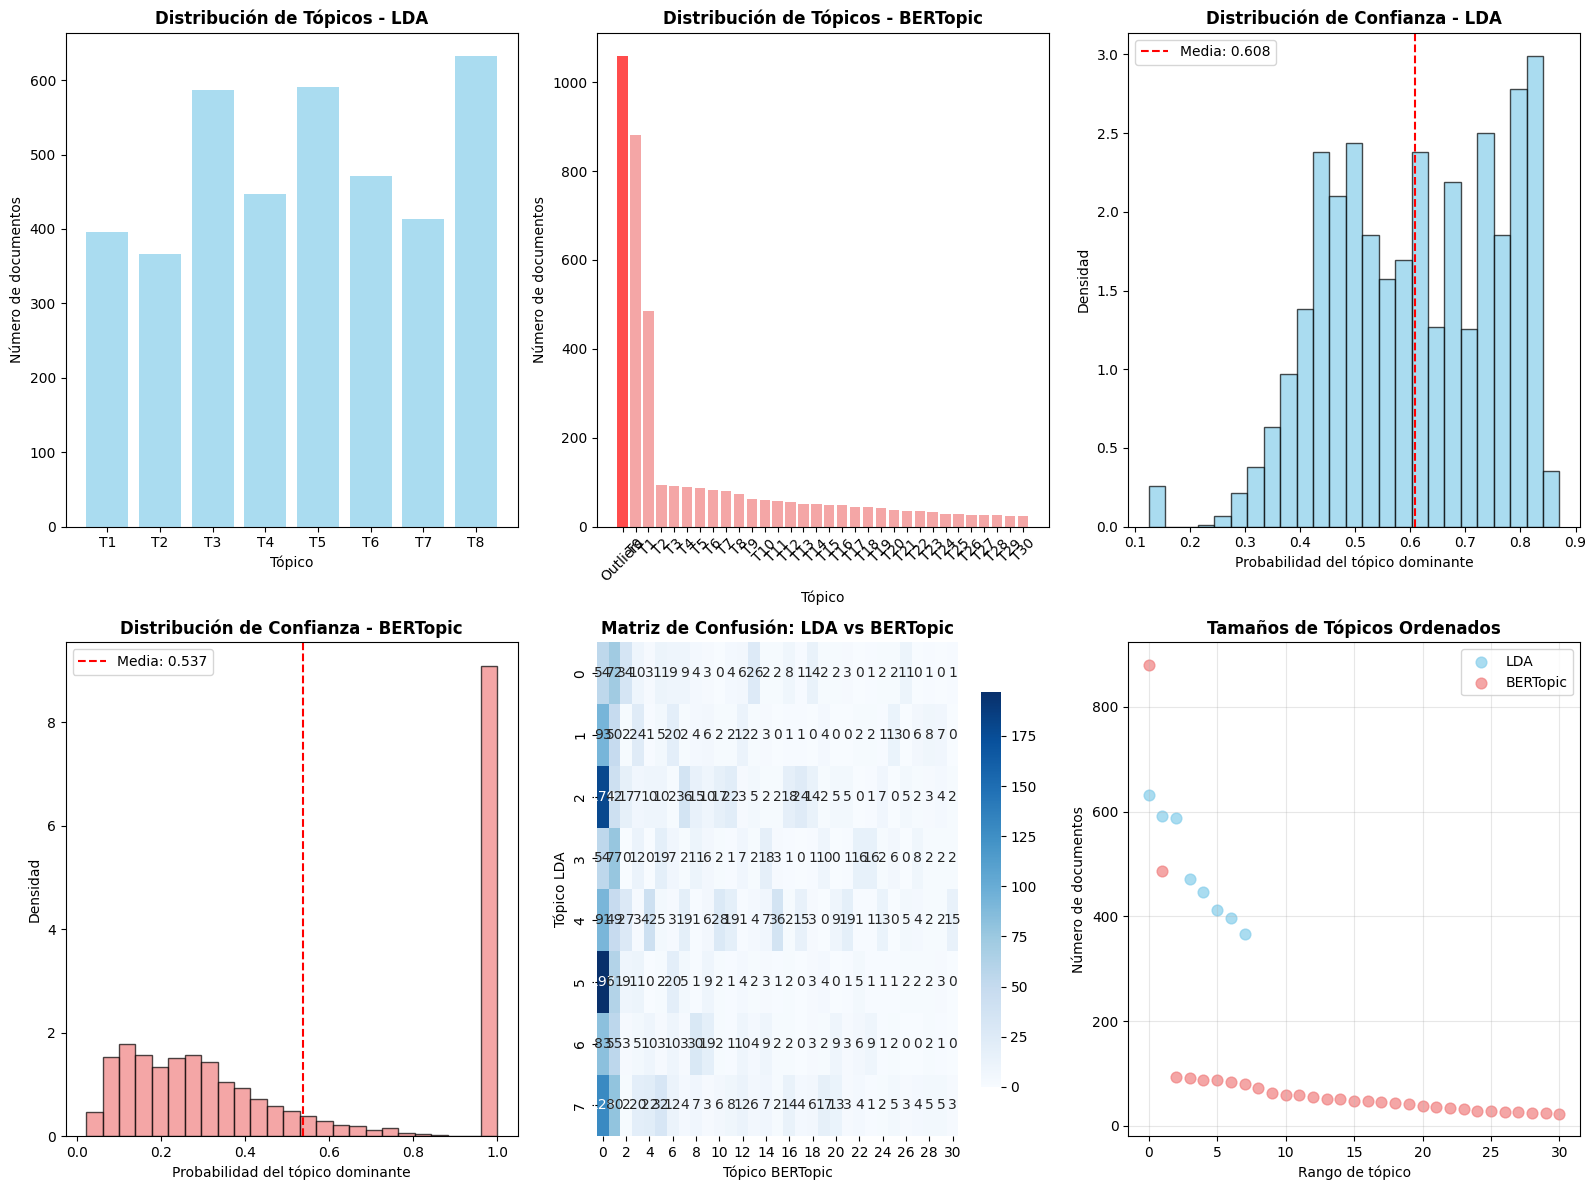

In [ ]:
print("=== VISUALIZACIONES COMPARATIVAS ===")

# Configurar figura con múltiples subplots
fig = plt.figure(figsize=(16, 12))

# 1. Distribución de tópicos por método
ax1 = plt.subplot(2, 3, 1)
distribucion_lda = df['topico_lda'].value_counts().sort_index()
ax1.bar(range(len(distribucion_lda)), distribucion_lda.values, color='skyblue', alpha=0.7)
ax1.set_title('Distribución de Tópicos - LDA', fontsize=12, fontweight='bold')
ax1.set_xlabel('Tópico')
ax1.set_ylabel('Número de documentos')
ax1.set_xticks(range(len(distribucion_lda)))
ax1.set_xticklabels([f'T{i+1}' for i in range(len(distribucion_lda))])

ax2 = plt.subplot(2, 3, 2)
distribucion_bert = df['topico_bertopic'].value_counts().sort_index()
colors = ['red' if x == -1 else 'lightcoral' for x in distribucion_bert.index]
bars = ax2.bar(range(len(distribucion_bert)), distribucion_bert.values, color=colors, alpha=0.7)
ax2.set_title('Distribución de Tópicos - BERTopic', fontsize=12, fontweight='bold')
ax2.set_xlabel('Tópico')
ax2.set_ylabel('Número de documentos')
# Etiquetas personalizadas para incluir outliers
labels = ['Outliers' if x == -1 else f'T{x}' for x in distribucion_bert.index]
ax2.set_xticks(range(len(distribucion_bert)))
ax2.set_xticklabels(labels, rotation=45)

# 2. Distribución de probabilidades/confianza
ax3 = plt.subplot(2, 3, 3)
ax3.hist(df['probabilidad_lda'], bins=25, alpha=0.7, color='skyblue', edgecolor='black', density=True)
ax3.set_title('Distribución de Confianza - LDA', fontsize=12, fontweight='bold')
ax3.set_xlabel('Probabilidad del tópico dominante')
ax3.set_ylabel('Densidad')
ax3.axvline(df['probabilidad_lda'].mean(), color='red', linestyle='--', label=f'Media: {df["probabilidad_lda"].mean():.3f}')
ax3.legend()

ax4 = plt.subplot(2, 3, 4)
if probabilities_bertopic is not None:
    probs_bert_valid = df[df['topico_bertopic'] != -1]['probabilidad_bertopic']
    ax4.hist(probs_bert_valid, bins=25, alpha=0.7, color='lightcoral', edgecolor='black', density=True)
    ax4.axvline(probs_bert_valid.mean(), color='red', linestyle='--', label=f'Media: {probs_bert_valid.mean():.3f}')
    ax4.legend()
ax4.set_title('Distribución de Confianza - BERTopic', fontsize=12, fontweight='bold')
ax4.set_xlabel('Probabilidad del tópico dominante')
ax4.set_ylabel('Densidad')

# 3. Matriz de confusión entre métodos (para documentos con tópicos válidos)
ax5 = plt.subplot(2, 3, 5)
df_valid = df[df['topico_bertopic'] != -1]  # Solo documentos con tópicos válidos en BERTopic
if len(df_valid) > 0:
    confusion_matrix = pd.crosstab(df_valid['topico_lda'], df_valid['topico_bertopic'])
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax5, cbar_kws={'shrink': 0.8})
    ax5.set_title('Matriz de Confusión: LDA vs BERTopic', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Tópico BERTopic')
    ax5.set_ylabel('Tópico LDA')

# 4. Comparación de coherencia por tamaño de tópico
ax6 = plt.subplot(2, 3, 6)
# Calcular tamaños de tópicos
lda_sizes = distribucion_lda.values
bert_sizes = [v for k, v in distribucion_bert.items() if k != -1]

# Crear scatter plot comparativo
ax6.scatter(range(len(lda_sizes)), sorted(lda_sizes, reverse=True),
           color='skyblue', alpha=0.7, s=60, label='LDA')
ax6.scatter(range(len(bert_sizes)), sorted(bert_sizes, reverse=True),
           color='lightcoral', alpha=0.7, s=60, label='BERTopic')
ax6.set_title('Tamaños de Tópicos Ordenados', fontsize=12, fontweight='bold')
ax6.set_xlabel('Rango de tópico')
ax6.set_ylabel('Número de documentos')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Análisis de solapamiento entre métodos
print("\n=== ANÁLISIS DE SOLAPAMIENTO ===")
if len(df_valid) > 0:
    # Calcular acuerdo entre métodos
    total_comparables = len(df_valid)
    print(f"Documentos comparables (excl. outliers BERTopic): {total_comparables:,}")

    # Analizar qué tan bien se correlacionan las asignaciones
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

    ari_score = adjusted_rand_score(df_valid['topico_lda'], df_valid['topico_bertopic'])
    nmi_score = normalized_mutual_info_score(df_valid['topico_lda'], df_valid['topico_bertopic'])

    print(f"Adjusted Rand Index: {ari_score:.3f} (rango: -1 a 1, 1 = acuerdo perfecto)")
    print(f"Normalized Mutual Information: {nmi_score:.3f} (rango: 0 a 1, 1 = información compartida máxima)")

    if ari_score > 0.3:
        print("→ Los métodos muestran acuerdo sustancial en las asignaciones")
    elif ari_score > 0.1:
        print("→ Los métodos muestran acuerdo moderado en las asignaciones")
    else:
        print("→ Los métodos identifican estructuras de tópicos diferentes")


=== ANÁLISIS DE SOLAPAMIENTO ===
Documentos comparables (excl. outliers BERTopic): 2,846
Adjusted Rand Index: 0.027 (rango: -1 a 1, 1 = acuerdo perfecto)
Normalized Mutual Information: 0.112 (rango: 0 a 1, 1 = información compartida máxima)
→ Los métodos identifican estructuras de tópicos diferentes



## 6.3 Análisis cualitativo de tópicos

In [ ]:
def comparar_topicos_cualitativamente():
    """
    Compara la calidad e interpretabilidad de los tópicos
    encontrados por cada método.
    """
    print("=== COMPARACIÓN CUALITATIVA DE TÓPICOS ===")

    print("\n--- COHERENCIA TEMÁTICA ---")
    print("LDA - Tópicos identificados:")
    for i, (topico_id, palabras) in enumerate(topicos_lda.items()):
        palabras_top = [palabra for palabra, _ in palabras[:5]]
        print(f"  Tópico {topico_id + 1}: {' | '.join(palabras_top)}")

    print("\nBERTopic - Tópicos identificados:")
    for _, row in topicos_bertopic_info.head(len(topicos_lda)).iterrows():
        topic_id = row['Topic']
        topic_words = bertopic_model.get_topic(topic_id)
        palabras_top = [palabra for palabra, _ in topic_words[:5]]
        print(f"  Tópico {topic_id}: {' | '.join(palabras_top)}")

    print("\n--- EVALUACIÓN CUALITATIVA ---")
    print("Criterios de evaluación:")
    print("1. Coherencia semántica: ¿Las palabras del tópico están relacionadas?")
    print("2. Interpretabilidad: ¿Es fácil identificar el tema subyacente?")
    print("3. Especificidad: ¿El tópico es suficientemente específico?")
    print("4. Diversidad: ¿Los tópicos cubren diferentes aspectos del corpus?")

    print("\nCaracterísticas observadas:")
    print("LDA:")
    print("  + Produce número fijo y balanceado de tópicos")
    print("  + Buena cobertura del corpus (100%)")
    print("  - Puede generar tópicos menos coherentes semánticamente")
    print("  - Asignaciones forzadas incluso para documentos atípicos")

    print("\nBERTopic:")
    print("  + Tópicos más coherentes semánticamente")
    print("  + Identifica documentos outliers (mayor precisión)")
    print("  + Número de tópicos determinado por los datos")
    print("  - Menor cobertura del corpus")
    print("  - Puede ser menos estable entre ejecuciones")

In [ ]:
comparar_topicos_cualitativamente()

=== COMPARACIÓN CUALITATIVA DE TÓPICOS ===

--- COHERENCIA TEMÁTICA ---
LDA - Tópicos identificados:
  Tópico 1: salud | climático | cambio | san | vida
  Tópico 2: sociedad | él | fuerza | policía | venezuela
  Tópico 3: país | colombia | gobierno | región | reunión
  Tópico 4: pacto | favor | vía | histórico | pacto histórico
  Tópico 5: bogotá | metro | público | millón | educación
  Tópico 6: colombia | humano | colombia humano | social | colombiano
  Tópico 7: debate | solidaridad | petro | familia | periódico
  Tópico 8: colombia | mil | duque | millón | tierra

BERTopic - Tópicos identificados:
  Tópico 0: colombia | colombiano | colombia humano | humano | paz
  Tópico 1: uribir | gracias | acabar | medellín | carlos
  Tópico 2: salud | hospital | sistema | sistema salud | eps
  Tópico 3: terrorista | matar | terrorismo | joven | masacre
  Tópico 4: deuda | billón | tributario | crédito | tasa
  Tópico 5: droga | consumo | narcotráfico | tonelada | narco
  Tópico 6: paz | violen

 # 7. Análisis Temporal Avanzado
 El análisis temporal nos permite entender cómo evolucionan los temas de discusión política a lo largo del tiempo, identificando tendencias, eventos significativos y cambios en la agenda.

## 7.1 Evolución temporal por trimestres

=== ANÁLISIS TEMPORAL POR TRIMESTRES ===
Preparando datos temporales...
Períodos analizados: 23 trimestres
Rango temporal: 2019-Q1 - 2024-Q3


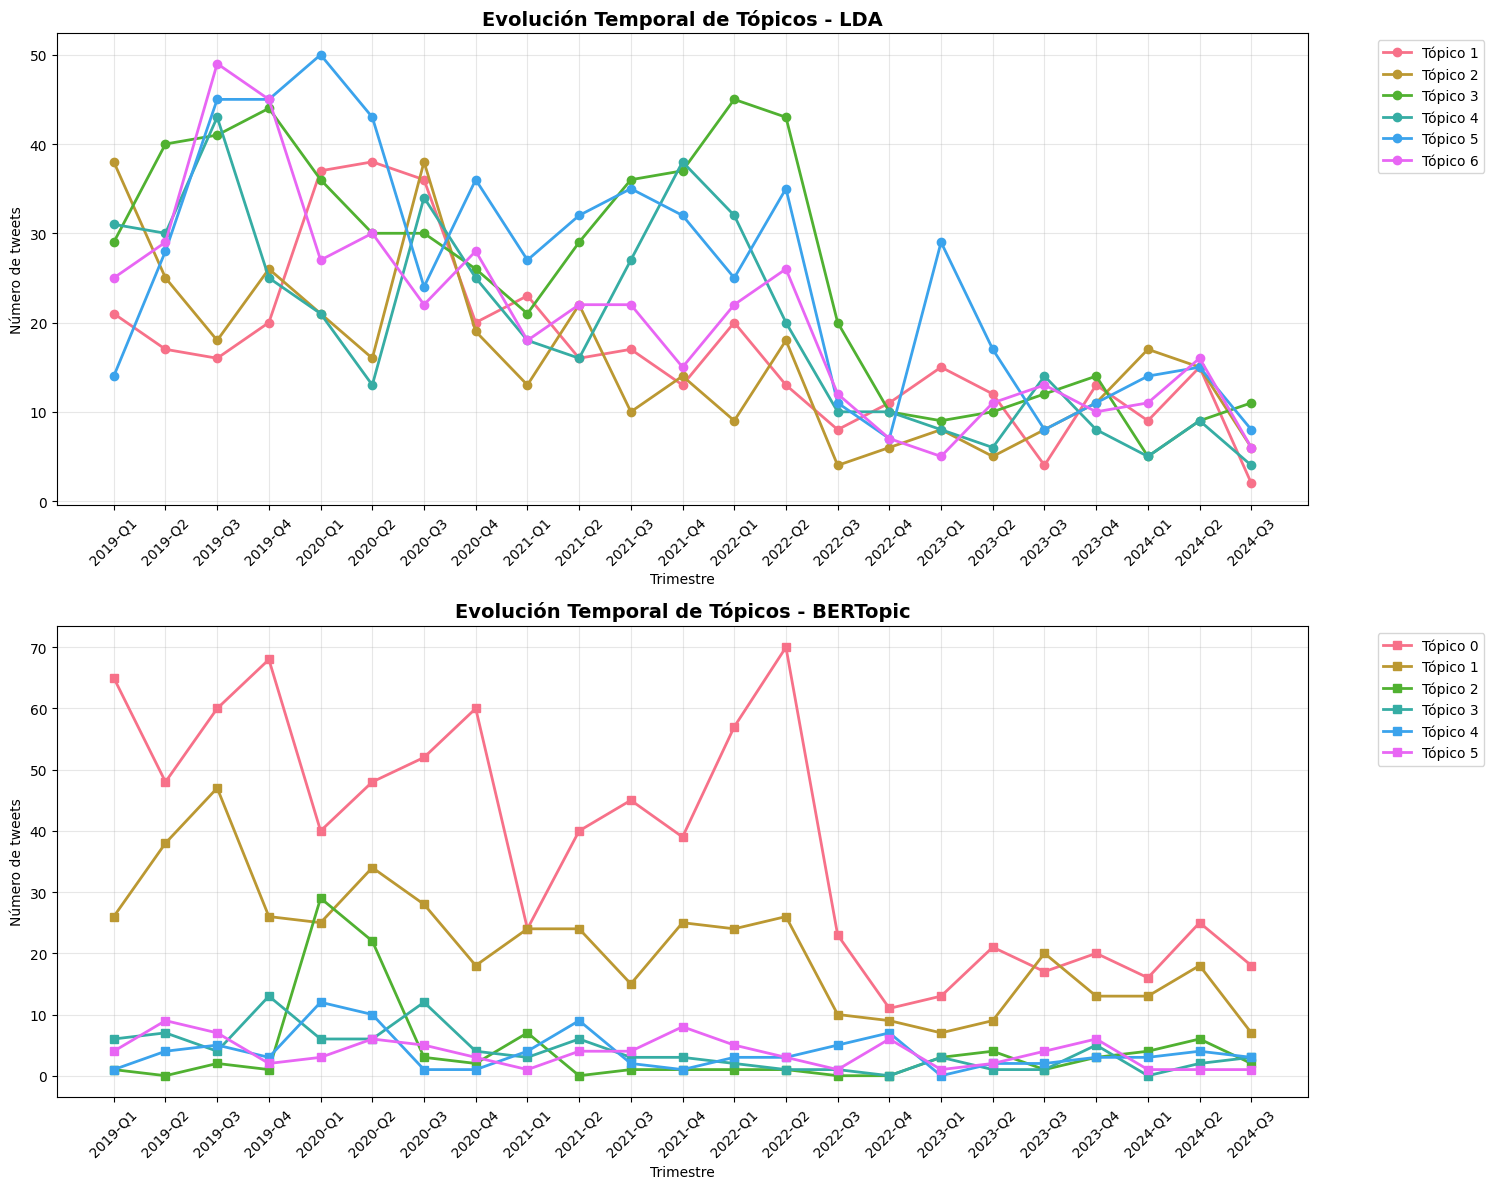

In [ ]:
print("=== ANÁLISIS TEMPORAL POR TRIMESTRES ===")

# Preparar datos temporales usando la columna año_trimestre
print("Preparando datos temporales...")

# Crear análisis temporal para LDA
temporal_lda = df.groupby(['año_trimestre', 'topico_lda']).size().unstack(fill_value=0)
print(f"Períodos analizados: {len(temporal_lda)} trimestres")
print(f"Rango temporal: {temporal_lda.index.min()} - {temporal_lda.index.max()}")

# Crear análisis temporal para BERTopic (excluyendo outliers)
df_bertopic_valid = df[df['topico_bertopic'] != -1]
if len(df_bertopic_valid) > 0:
    temporal_bertopic = df_bertopic_valid.groupby(['año_trimestre', 'topico_bertopic']).size().unstack(fill_value=0)
else:
    temporal_bertopic = pd.DataFrame()

# Visualización de evolución temporal
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Evolución LDA
ax1 = axes[0]
for topico in range(min(6, n_topics_lda)):  # Mostrar máximo 6 tópicos para claridad
    ax1.plot(temporal_lda.index, temporal_lda[topico],
             marker='o', linewidth=2, markersize=6, label=f'Tópico {topico + 1}')

ax1.set_title('Evolución Temporal de Tópicos - LDA', fontsize=14, fontweight='bold')
ax1.set_xlabel('Trimestre')
ax1.set_ylabel('Número de tweets')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Evolución BERTopic
ax2 = axes[1]
if not temporal_bertopic.empty:
    topicos_principales = temporal_bertopic.sum().nlargest(6).index  # Top 6 tópicos
    for topico in topicos_principales:
        ax2.plot(temporal_bertopic.index, temporal_bertopic[topico],
                 marker='s', linewidth=2, markersize=6, label=f'Tópico {topico}')

    ax2.set_title('Evolución Temporal de Tópicos - BERTopic', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Trimestre')
    ax2.set_ylabel('Número de tweets')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Estadísticas temporales
print("\n=== ESTADÍSTICAS TEMPORALES ===")

# Identificar períodos más activos
actividad_por_periodo = df.groupby('año_trimestre').size()
print("Actividad por trimestre:")
for periodo, cantidad in actividad_por_periodo.items():
    print(f"  {periodo}: {cantidad:,} tweets")

periodo_mas_activo = actividad_por_periodo.idxmax()
print(f"\nPeríodo más activo: {periodo_mas_activo} ({actividad_por_periodo.max():,} tweets)")

# Analizar variabilidad temporal de cada tópico
print("\nVariabilidad temporal de tópicos (LDA):")
for topico in range(n_topics_lda):
    serie_temporal = temporal_lda[topico]
    coef_variacion = serie_temporal.std() / serie_temporal.mean() if serie_temporal.mean() > 0 else 0
    print(f"  Tópico {topico + 1}: CV = {coef_variacion:.3f} ({'Estable' if coef_variacion < 0.5 else 'Variable'})")


=== ESTADÍSTICAS TEMPORALES ===
Actividad por trimestre:
  2019-Q1: 210 tweets
  2019-Q2: 224 tweets
  2019-Q3: 283 tweets
  2019-Q4: 266 tweets
  2020-Q1: 258 tweets
  2020-Q2: 245 tweets
  2020-Q3: 235 tweets
  2020-Q4: 203 tweets
  2021-Q1: 167 tweets
  2021-Q2: 197 tweets
  2021-Q3: 191 tweets
  2021-Q4: 196 tweets
  2022-Q1: 196 tweets
  2022-Q2: 202 tweets
  2022-Q3: 105 tweets
  2022-Q4: 84 tweets
  2023-Q1: 109 tweets
  2023-Q2: 90 tweets
  2023-Q3: 92 tweets
  2023-Q4: 95 tweets
  2024-Q1: 83 tweets
  2024-Q2: 116 tweets
  2024-Q3: 57 tweets

Período más activo: 2019-Q3 (283 tweets)

Variabilidad temporal de tópicos (LDA):
  Tópico 1: CV = 0.545 (Variable)
  Tópico 2: CV = 0.589 (Variable)
  Tópico 3: CV = 0.523 (Variable)
  Tópico 4: CV = 0.591 (Variable)
  Tópico 5: CV = 0.517 (Variable)
  Tópico 6: CV = 0.555 (Variable)
  Tópico 7: CV = 0.386 (Estable)
  Tópico 8: CV = 0.434 (Estable)


## 7.2 Detección de eventos y cambios temáticos

In [ ]:
def detectar_eventos_tematicos(datos_temporales, umbral_cambio=2.0):
    """
    Detecta cambios significativos en la frecuencia de tópicos
    que podrían indicar eventos importantes.
    """
    print("=== DETECCIÓN DE EVENTOS TEMÁTICOS ===")

    eventos_detectados = []

    for topico in datos_temporales.columns:
        serie = datos_temporales[topico]

        # Calcular cambios porcentuales entre períodos
        cambios = serie.pct_change().fillna(0)

        # Identificar cambios significativos
        cambios_significativos = cambios[abs(cambios) > umbral_cambio]

        if len(cambios_significativos) > 0:
            print(f"\nTópico {topico + 1 if isinstance(topico, int) else topico}:")
            for periodo, cambio in cambios_significativos.items():
                direccion = "↑" if cambio > 0 else "↓"
                eventos_detectados.append((periodo, topico, cambio))
                print(f"  {periodo}: {direccion} {abs(cambio)*100:.1f}% de cambio")

    return eventos_detectados

In [ ]:
# Detectar eventos para LDA
eventos_lda = detectar_eventos_tematicos(temporal_lda)

# Detectar eventos para BERTopic si hay datos válidos
if not temporal_bertopic.empty:
    eventos_bertopic = detectar_eventos_tematicos(temporal_bertopic)

# Análisis de correlaciones temporales entre tópicos
print("\n=== CORRELACIONES TEMPORALES ENTRE TÓPICOS ===")

correlaciones_lda = temporal_lda.corr()
print("Correlaciones más fuertes entre tópicos LDA:")

# Encontrar correlaciones significativas (excluyendo diagonal)
correlaciones_significativas = []
for i in range(len(correlaciones_lda.columns)):
    for j in range(i+1, len(correlaciones_lda.columns)):
        corr = correlaciones_lda.iloc[i, j]
        if abs(corr) > 0.5:  # Umbral de correlación significativa
            correlaciones_significativas.append((
                correlaciones_lda.index[i],
                correlaciones_lda.columns[j],
                corr
            ))

correlaciones_significativas.sort(key=lambda x: abs(x[2]), reverse=True)
for top1, top2, corr in correlaciones_significativas[:5]:
    print(f"  Tópico {top1 + 1} ↔ Tópico {top2 + 1}: r = {corr:.3f}")

if len(correlaciones_significativas) == 0:
    print("  No se encontraron correlaciones significativas (|r| > 0.5)")

=== DETECCIÓN DE EVENTOS TEMÁTICOS ===

Tópico 1:
  2023-Q4: ↑ 225.0% de cambio

Tópico 5:
  2023-Q1: ↑ 314.3% de cambio
=== DETECCIÓN DE EVENTOS TEMÁTICOS ===

Tópico 3:
  2019-Q3: ↑ inf% de cambio
  2020-Q1: ↑ 2800.0% de cambio
  2021-Q1: ↑ 250.0% de cambio
  2021-Q3: ↑ inf% de cambio
  2023-Q1: ↑ inf% de cambio

Tópico 4:
  2019-Q4: ↑ 225.0% de cambio
  2023-Q1: ↑ inf% de cambio
  2023-Q4: ↑ 400.0% de cambio
  2024-Q2: ↑ inf% de cambio

Tópico 5:
  2019-Q2: ↑ 300.0% de cambio
  2020-Q1: ↑ 300.0% de cambio
  2021-Q1: ↑ 300.0% de cambio
  2023-Q2: ↑ inf% de cambio

Tópico 6:
  2021-Q2: ↑ 300.0% de cambio
  2022-Q4: ↑ 500.0% de cambio

Tópico 7:
  2019-Q4: ↑ 250.0% de cambio
  2022-Q4: ↑ inf% de cambio

Tópico 8:
  2019-Q2: ↑ 300.0% de cambio
  2023-Q1: ↑ inf% de cambio
  2023-Q4: ↑ inf% de cambio
  2024-Q1: ↑ 300.0% de cambio
  2024-Q3: ↑ inf% de cambio

Tópico 9:
  2023-Q4: ↑ 400.0% de cambio

Tópico 10:
  2019-Q3: ↑ 400.0% de cambio
  2020-Q3: ↑ inf% de cambio
  2021-Q1: ↑ 300.0% de

## 7.3 Análisis por político y período

=== ANÁLISIS TEMPORAL POR POLÍTICO ===


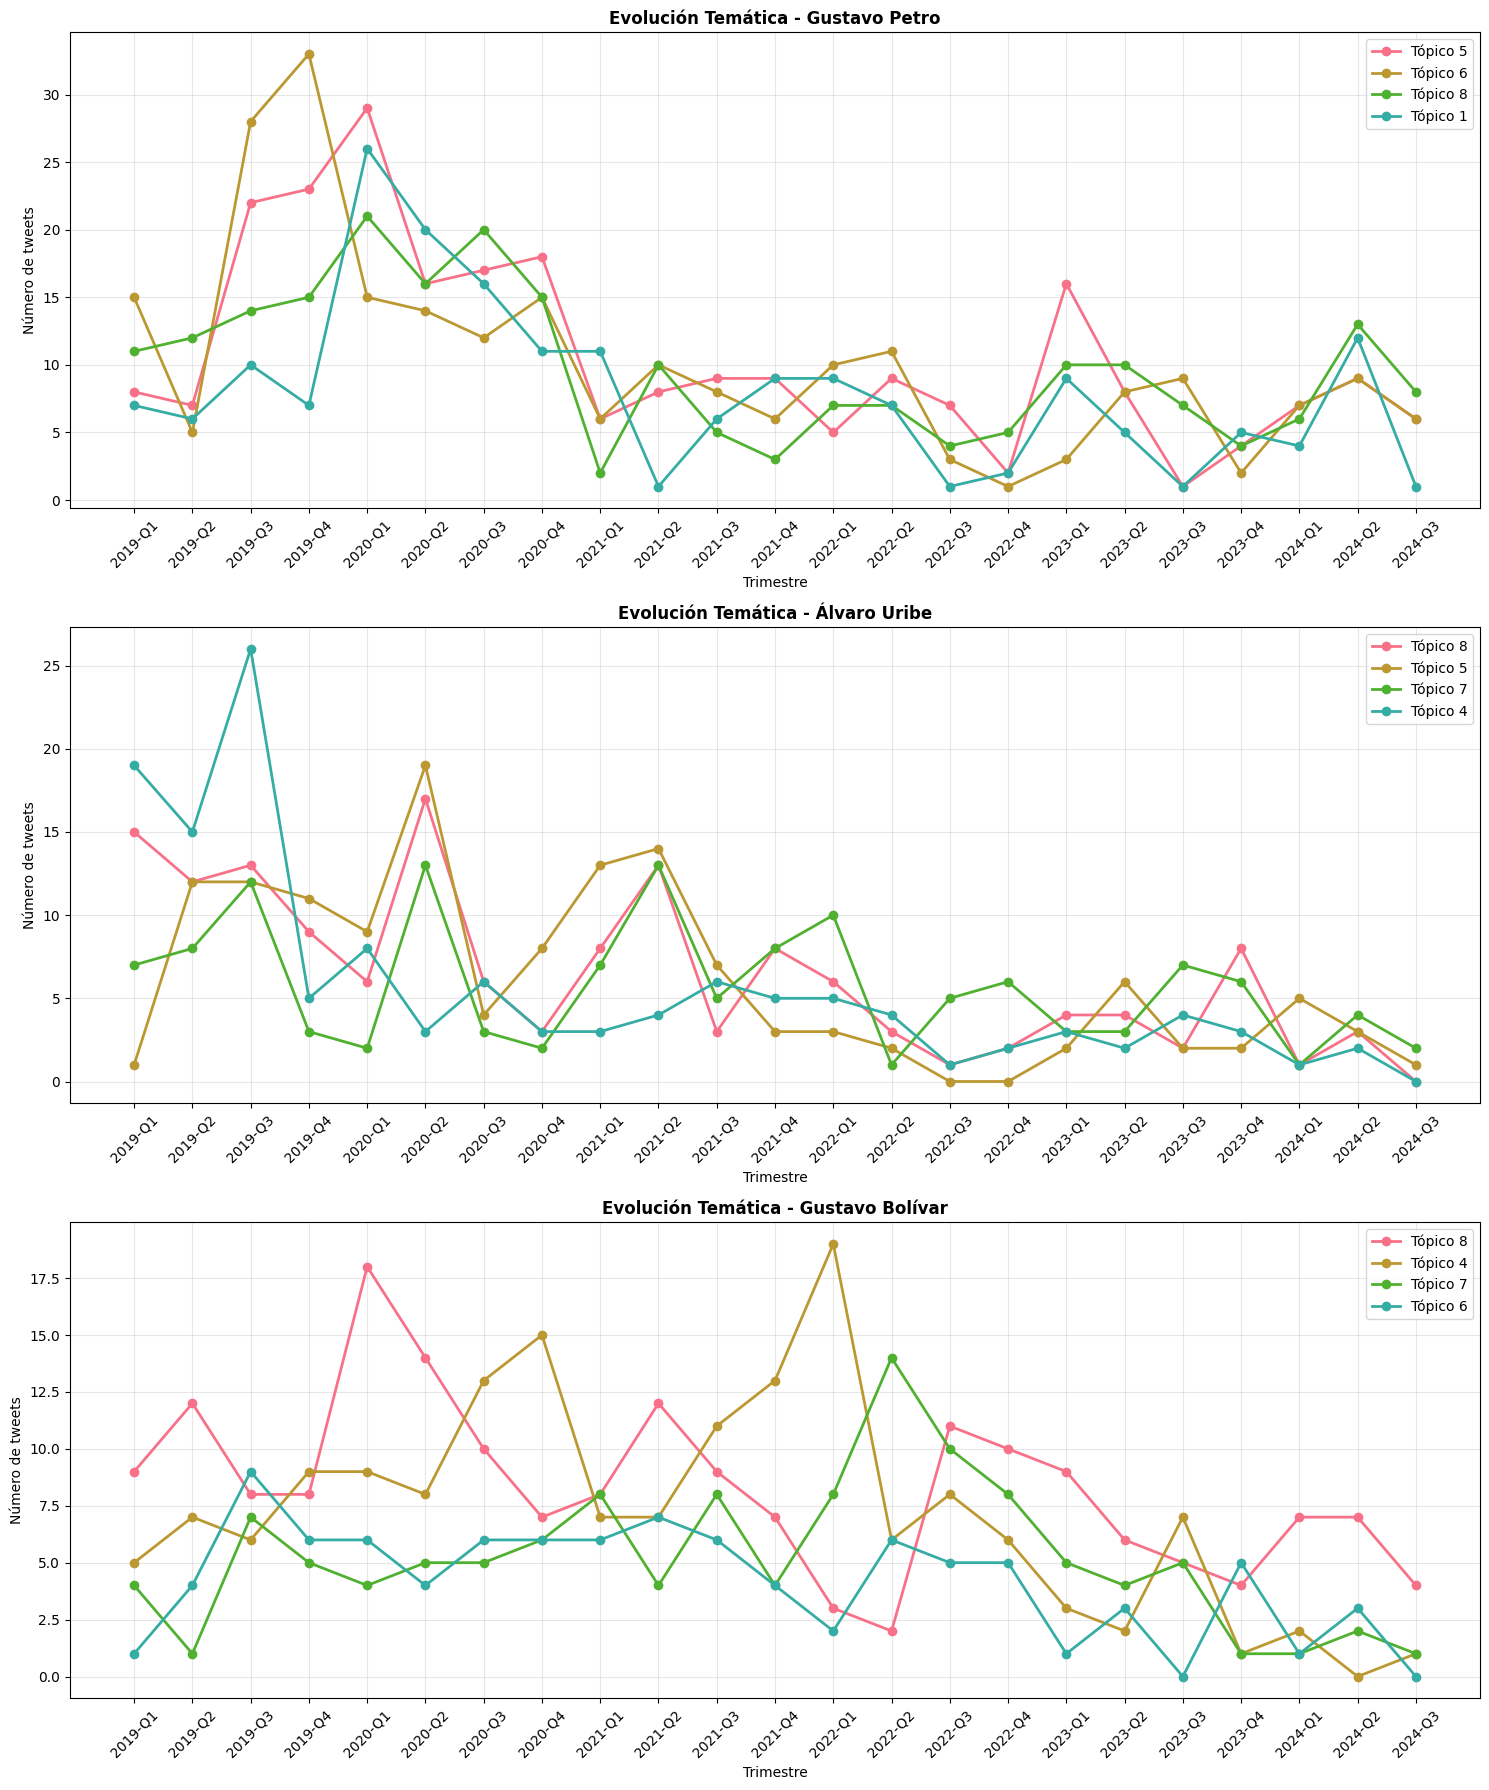

In [ ]:
print("=== ANÁLISIS TEMPORAL POR POLÍTICO ===")

# Crear análisis cruzado: político x período x tópico
politico_temporal = df.groupby(['politico', 'año_trimestre', 'topico_lda']).size().unstack(fill_value=0)

# Visualizar evolución temática por político principal
politicos_principales = df['politico'].value_counts().head(3).index

fig, axes = plt.subplots(len(politicos_principales), 1, figsize=(15, 6*len(politicos_principales)))
if len(politicos_principales) == 1:
    axes = [axes]

for idx, politico in enumerate(politicos_principales):
    ax = axes[idx]

    # Datos del político específico
    datos_politico = df[df['politico'] == politico]
    temporal_politico = datos_politico.groupby(['año_trimestre', 'topico_lda']).size().unstack(fill_value=0)

    # Mostrar evolución de sus tópicos principales
    topicos_principales_pol = temporal_politico.sum().nlargest(4).index

    for topico in topicos_principales_pol:
        if topico in temporal_politico.columns:
            ax.plot(temporal_politico.index, temporal_politico[topico],
                   marker='o', linewidth=2, label=f'Tópico {topico + 1}')

    ax.set_title(f'Evolución Temática - {politico}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Trimestre')
    ax.set_ylabel('Número de tweets')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Análisis de especialización temática por período
print("\n=== ESPECIALIZACIÓN TEMÁTICA POR PERÍODO ===")

for periodo in sorted(df['año_trimestre'].unique())[-4:]:  # Últimos 4 trimestres
    print(f"\n{periodo}:")
    datos_periodo = df[df['año_trimestre'] == periodo]

    if len(datos_periodo) > 0:
        # Tópicos dominantes del período
        topicos_periodo = datos_periodo['topico_lda'].value_counts()
        total_tweets = len(datos_periodo)

        print(f"  Total tweets: {total_tweets:,}")
        print("  Tópicos dominantes:")
        for topico, cantidad in topicos_periodo.head(3).items():
            porcentaje = (cantidad / total_tweets) * 100
            print(f"    Tópico {topico + 1}: {cantidad:,} tweets ({porcentaje:.1f}%)")

        # Políticos más activos del período
        politicos_periodo = datos_periodo['politico'].value_counts()
        print("  Políticos más activos:")
        for politico, cantidad in politicos_periodo.head(3).items():
            porcentaje = (cantidad / total_tweets) * 100
            print(f"    {politico}: {cantidad:,} tweets ({porcentaje:.1f}%)")


=== ESPECIALIZACIÓN TEMÁTICA POR PERÍODO ===

2023-Q4:
  Total tweets: 95
  Tópicos dominantes:
    Tópico 8: 18 tweets (18.9%)
    Tópico 3: 14 tweets (14.7%)
    Tópico 1: 13 tweets (13.7%)
  Políticos más activos:
    Álvaro Uribe: 30 tweets (31.6%)
    Gustavo Petro: 29 tweets (30.5%)
    Gustavo Bolívar: 25 tweets (26.3%)

2024-Q1:
  Total tweets: 83
  Tópicos dominantes:
    Tópico 2: 17 tweets (20.5%)
    Tópico 8: 15 tweets (18.1%)
    Tópico 5: 14 tweets (16.9%)
  Políticos más activos:
    Gustavo Petro: 40 tweets (48.2%)
    Gustavo Bolívar: 21 tweets (25.3%)
    Álvaro Uribe: 16 tweets (19.3%)

2024-Q2:
  Total tweets: 116
  Tópicos dominantes:
    Tópico 8: 24 tweets (20.7%)
    Tópico 6: 16 tweets (13.8%)
    Tópico 2: 15 tweets (12.9%)
  Políticos más activos:
    Gustavo Petro: 65 tweets (56.0%)
    Álvaro Uribe: 21 tweets (18.1%)
    Gustavo Bolívar: 19 tweets (16.4%)

2024-Q3:
  Total tweets: 57
  Tópicos dominantes:
    Tópico 8: 12 tweets (21.1%)
    Tópico 3: 11 t

# 8. Visualizaciones Avanzadas y Análisis de Palabras

## 8.1 Nubes de palabras temáticas

In [ ]:
print("=== GENERACIÓN DE NUBES DE PALABRAS ===")

def crear_nubes_palabras_por_topico(dataframe, columna_topico, prefijo_titulo, max_topicos=6):
    """
    Crea nubes de palabras para cada tópico identificado.
    """
    # Determinar layout de subplots
    n_topicos = min(max_topicos, len(dataframe[columna_topico].unique()))
    if -1 in dataframe[columna_topico].unique():
        n_topicos = min(max_topicos, len(dataframe[columna_topico].unique()) - 1)

    if n_topicos == 0:
        print(f"No hay tópicos válidos para {prefijo_titulo}")
        return

    cols = 3
    rows = (n_topicos + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if rows == 1:
        axes = axes.reshape(1, -1) if n_topicos > 1 else [axes]
    axes = axes.flatten()

    # Obtener tópicos válidos
    topicos_validos = [t for t in sorted(dataframe[columna_topico].unique()) if t != -1][:max_topicos]

    for idx, topico in enumerate(topicos_validos):
        # Obtener textos del tópico
        textos_topico = dataframe[dataframe[columna_topico] == topico]['texto_procesado']
        texto_combinado = ' '.join(textos_topico)

        if len(texto_combinado.strip()) > 0:
            # Crear nube de palabras
            wordcloud = WordCloud(
                width=400,
                height=300,
                background_color='white',
                max_words=50,
                colormap='Set2',
                relative_scaling=0.5,
                min_font_size=8
            ).generate(texto_combinado)

            axes[idx].imshow(wordcloud, interpolation='bilinear')
            axes[idx].set_title(f'{prefijo_titulo} - Tópico {topico + 1 if topico >= 0 else topico}',
                              fontsize=12, fontweight='bold')
            axes[idx].axis('off')
        else:
            axes[idx].text(0.5, 0.5, 'Sin datos\nsuficientes',
                          horizontalalignment='center', verticalalignment='center',
                          transform=axes[idx].transAxes, fontsize=12)
            axes[idx].set_title(f'{prefijo_titulo} - Tópico {topico + 1 if topico >= 0 else topico}')
            axes[idx].axis('off')

    # Ocultar subplots vacíos
    for idx in range(len(topicos_validos), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

=== GENERACIÓN DE NUBES DE PALABRAS ===


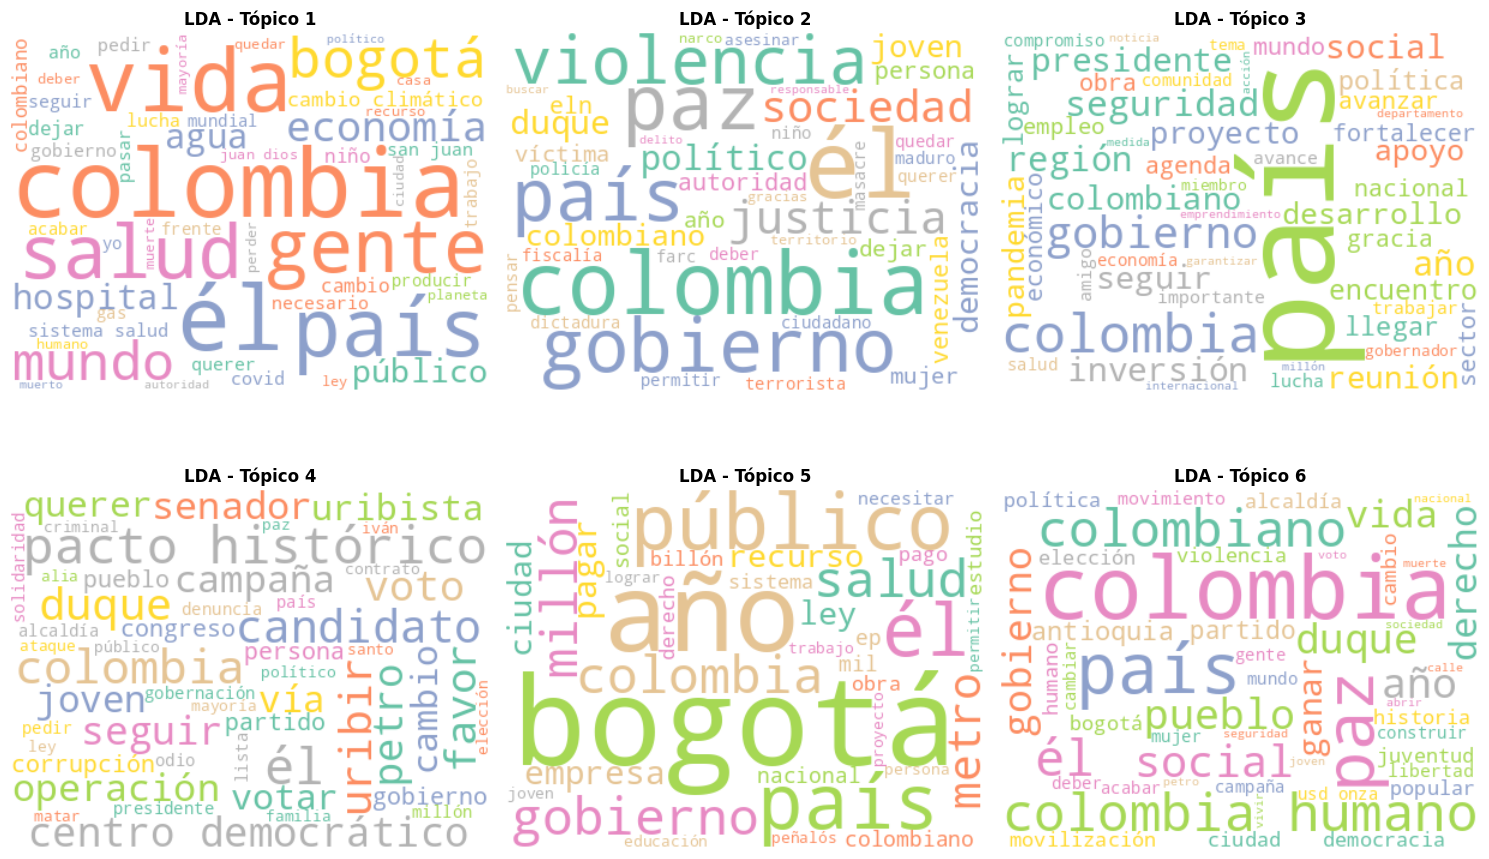

In [ ]:
# Crear nubes de palabras para LDA
crear_nubes_palabras_por_topico(df, 'topico_lda', 'LDA')

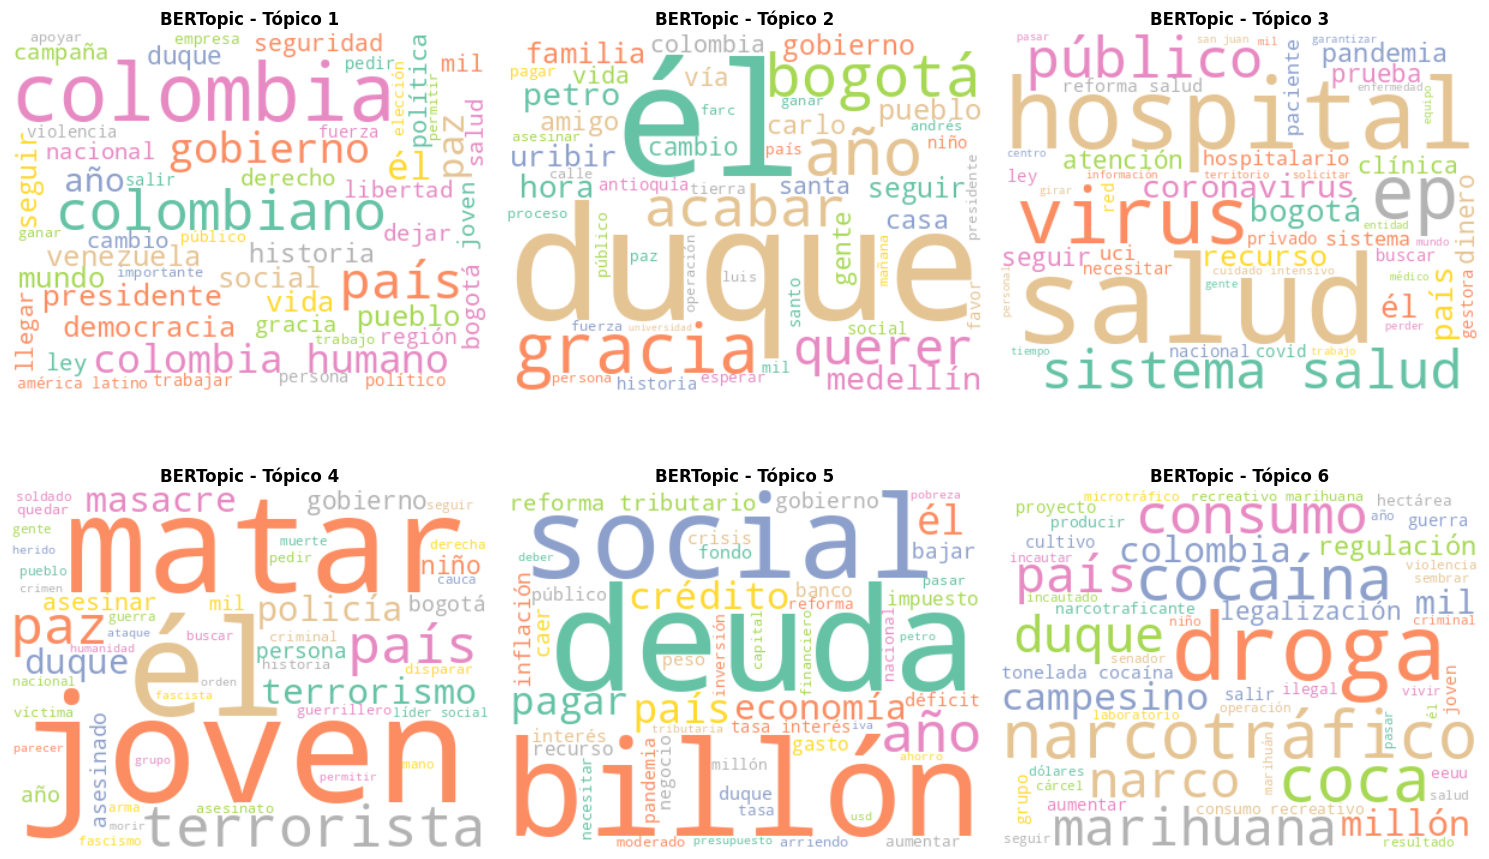

In [ ]:
# Crear nubes de palabras para BERTopic
crear_nubes_palabras_por_topico(df, 'topico_bertopic', 'BERTopic')

## 8.2 Análisis de co-ocurrencia de palabras

In [ ]:
print("=== ANÁLISIS DE CO-OCURRENCIA DE PALABRAS ===")

def analizar_coocurrencia_por_topico(dataframe, topico_id, columna_topico, ventana=5):
   """
   Analiza co-ocurrencia de palabras dentro de un tópico específico.
   """
   # Filtrar textos del tópico
   textos_topico = dataframe[dataframe[columna_topico] == topico_id]['texto_procesado']

   # Construir matriz de co-ocurrencia
   coocurrencias = defaultdict(int)

   for texto in textos_topico:
       palabras = texto.split()
       for i, palabra1 in enumerate(palabras):
           for j in range(max(0, i-ventana), min(len(palabras), i+ventana+1)):
               if i != j:
                   palabra2 = palabras[j]
                   if palabra1 != palabra2:
                       par = tuple(sorted([palabra1, palabra2]))
                       coocurrencias[par] += 1

   return coocurrencias

In [ ]:
# Analizar co-ocurrencia para el tópico más grande de LDA
topico_mas_grande_lda = df['topico_lda'].value_counts().index[0]
cooc_lda = analizar_coocurrencia_por_topico(df, topico_mas_grande_lda, 'topico_lda')

print(f"Co-ocurrencias más frecuentes en Tópico LDA {topico_mas_grande_lda + 1}:")
cooc_ordenadas = sorted(cooc_lda.items(), key=lambda x: x[1], reverse=True)
for (palabra1, palabra2), freq in cooc_ordenadas[:15]:
   print(f"  {palabra1} ↔ {palabra2}: {freq} veces")

# Analizar co-ocurrencia para BERTopic si hay datos válidos
topicos_bertopic_validos = [t for t in df['topico_bertopic'].unique() if t != -1]
if topicos_bertopic_validos:
   topico_mas_grande_bert = df[df['topico_bertopic'].isin(topicos_bertopic_validos)]['topico_bertopic'].value_counts().index[0]
   cooc_bert = analizar_coocurrencia_por_topico(df, topico_mas_grande_bert, 'topico_bertopic')

   print(f"\nCo-ocurrencias más frecuentes en Tópico BERTopic {topico_mas_grande_bert}:")
   cooc_ordenadas_bert = sorted(cooc_bert.items(), key=lambda x: x[1], reverse=True)
   for (palabra1, palabra2), freq in cooc_ordenadas_bert[:15]:
       print(f"  {palabra1} ↔ {palabra2}: {freq} veces")

## 8.3 Mapas de calor de actividad temática

In [ ]:
print("=== MAPAS DE CALOR DE ACTIVIDAD TEMÁTICA ===")

# Crear mapa de calor: Político x Tópico para LDA
print("Generando mapa de calor Político x Tópico (LDA)...")

# Matriz político x tópico
matriz_politico_topico_lda = df.groupby(['politico', 'topico_lda']).size().unstack(fill_value=0)

# Normalizar por político (porcentajes)
matriz_normalizada_lda = matriz_politico_topico_lda.div(matriz_politico_topico_lda.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 8))
sns.heatmap(matriz_normalizada_lda,
            annot=True,
            fmt='.1f',
            cmap='YlOrRd',
            cbar_kws={'label': 'Porcentaje de tweets (%)'},
            xticklabels=[f'T{i+1}' for i in matriz_normalizada_lda.columns],
            yticklabels=matriz_normalizada_lda.index)
plt.title('Distribución Temática por Político - LDA\n(Porcentaje de tweets por tópico)',
          fontsize=14, fontweight='bold')
plt.xlabel('Tópico LDA')
plt.ylabel('Político')
plt.tight_layout()
plt.show()

# Crear mapa de calor temporal: Trimestre x Tópico
print("Generando mapa de calor Trimestre x Tópico (LDA)...")

# Matriz trimestre x tópico
matriz_temporal_lda = df.groupby(['año_trimestre', 'topico_lda']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(matriz_temporal_lda,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar_kws={'label': 'Número de tweets'},
            xticklabels=[f'T{i+1}' for i in matriz_temporal_lda.columns])
plt.title('Evolución Temporal de Tópicos - LDA\n(Número de tweets por trimestre)',
          fontsize=14, fontweight='bold')
plt.xlabel('Tópico LDA')
plt.ylabel('Trimestre')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Análisis de concentración temática
print("\n=== ANÁLISIS DE CONCENTRACIÓN TEMÁTICA ===")

# Calcular índice de concentración de Herfindahl para cada político
def calcular_concentracion_herfindahl(distribucion):
    """
    Calcula el índice de Herfindahl para medir concentración.
    Valores cercanos a 1 indican alta concentración, cercanos a 0 indican dispersión.
    """
    proporciones = distribucion / distribucion.sum()
    return (proporciones ** 2).sum()

concentracion_politicos = {}
for politico in df['politico'].unique():
    distribucion = df[df['politico'] == politico]['topico_lda'].value_counts()
    concentracion = calcular_concentracion_herfindahl(distribucion)
    concentracion_politicos[politico] = concentracion

# Ordenar por concentración
concentracion_ordenada = sorted(concentracion_politicos.items(), key=lambda x: x[1], reverse=True)

print("Índice de concentración temática por político (LDA):")
print("(1.0 = muy concentrado, 0.0 = muy disperso)")
for politico, concentracion in concentracion_ordenada:
    interpretacion = "Alta" if concentracion > 0.4 else "Media" if concentracion > 0.25 else "Baja"
    tweets_politico = len(df[df['politico'] == politico])
    print(f"  {politico}: {concentracion:.3f} ({interpretacion}) - {tweets_politico:,} tweets")

# 9. Funcionalidades Avanzadas de BERTopic
BERTopic ofrece capacidades avanzadas que van más allá del modelado básico de tópicos, incluyendo visualizaciones interactivas y análisis jerárquico.

## 9.1 Visualizaciones interactivas de BERTopic

In [ ]:
if len([t for t in df['topico_bertopic'].unique() if t != -1]) > 1:
    print("=== VISUALIZACIONES INTERACTIVAS BERTOPIC ===")

    try:
        # Visualización de tópicos en espacio 2D
        print("Generando visualización de tópicos en 2D...")
        fig_topics = bertopic_model.visualize_topics()
        fig_topics.show()
        print("→ Esta visualización muestra la similitud entre tópicos")
        print("  Tópicos cercanos comparten vocabulario similar")

    except Exception as e:
        print(f"Error en visualización 2D: {e}")

    try:
        # Visualización de términos por tópico (barchart)
        print("\nGenerando gráficos de barras por tópico...")
        # Mostrar solo los primeros 5 tópicos para evitar sobrecarga
        topicos_para_visualizar = [t for t in sorted(df['topico_bertopic'].unique()) if t != -1][:5]

        for topico in topicos_para_visualizar:
            fig_barchart = bertopic_model.visualize_barchart(topics=[topico])
            fig_barchart.show()

    except Exception as e:
        print(f"Error en gráficos de barras: {e}")

    try:
        # Mapa de calor de similitud entre tópicos
        print("\nGenerando mapa de calor de similitud...")
        fig_heatmap = bertopic_model.visualize_heatmap()
        fig_heatmap.show()
        print("→ Colores más intensos indican mayor similitud entre tópicos")

    except Exception as e:
        print(f"Error en mapa de calor: {e}")

else:
    print("=== VISUALIZACIONES BERTOPIC NO DISPONIBLES ===")
    print("Insuficientes tópicos válidos para generar visualizaciones interactivas")

## 9.2 Análisis jerárquico de tópicos

In [ ]:
if len([t for t in df['topico_bertopic'].unique() if t != -1]) > 2:
    print("=== ANÁLISIS JERÁRQUICO DE TÓPICOS ===")

    try:
        # Generar jerarquía de tópicos
        print("Generando jerarquía de tópicos...")
        hierarchical_topics = bertopic_model.hierarchical_topics(df['texto_procesado'].tolist())

        # Visualizar jerarquía
        print("Creando dendrograma jerárquico...")
        fig_hierarchy = bertopic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
        fig_hierarchy.show()

        print("→ El dendrograma muestra cómo se relacionan jerárquicamente los tópicos")
        print("  Tópicos que se unen temprano son más similares")

        # Mostrar información de la jerarquía
        print("\nInformación de la jerarquía:")
        print(f"Niveles jerárquicos: {len(hierarchical_topics)}")

        # Analizar fusiones más significativas
        if len(hierarchical_topics) > 5:
            print("\nFusiones más significativas (últimos 5 niveles):")
            for i, row in hierarchical_topics.tail().iterrows():
                parent_id = row['Parent_ID']
                topics_fusionados = [row['Topics_Left'], row['Topics_Right']]
                print(f"  Nivel {i}: Tópicos {topics_fusionados} → Tópico padre {parent_id}")

    except Exception as e:
        print(f"Error en análisis jerárquico: {e}")
        print("Esto puede ocurrir si hay muy pocos tópicos o problemas de memoria")

else:
    print("=== ANÁLISIS JERÁRQUICO NO DISPONIBLE ===")
    print("Se necesitan al menos 3 tópicos válidos para análisis jerárquico")

## 9.3 Análisis de evolución temporal con BERTopic

In [ ]:
if len(df[df['topico_bertopic'] != -1]) > 50:  # Suficientes datos para análisis temporal
    print("=== EVOLUCIÓN TEMPORAL CON BERTOPIC ===")

    try:
        # Preparar datos temporales
        df_temporal_bert = df[df['topico_bertopic'] != -1].copy()

        # Convertir fechas para BERTopic
        timestamps = pd.to_datetime(df_temporal_bert['fecha']).tolist()
        textos_temporales = df_temporal_bert['texto_procesado'].tolist()

        print("Analizando evolución temporal de tópicos...")
        topics_over_time = bertopic_model.topics_over_time(textos_temporales, timestamps, nr_bins=10)

        # Visualizar evolución temporal
        fig_temporal = bertopic_model.visualize_topics_over_time(topics_over_time)
        fig_temporal.show()

        print("→ Esta visualización muestra cómo cambia la frecuencia de cada tópico en el tiempo")

        # Analizar tendencias
        print("\nAnálisis de tendencias temporales:")
        for topic_id in topics_over_time['Topic'].unique():
            if topic_id != -1:  # Excluir outliers
                topic_data = topics_over_time[topics_over_time['Topic'] == topic_id]
                if len(topic_data) > 1:
                    # Calcular tendencia simple
                    frecuencias = topic_data['Frequency'].values
                    tendencia = "Creciente" if frecuencias[-1] > frecuencias[0] else "Decreciente"
                    variabilidad = np.std(frecuencias) / np.mean(frecuencias) if np.mean(frecuencias) > 0 else 0

                    print(f"  Tópico {topic_id}: {tendencia}, variabilidad: {variabilidad:.3f}")

    except Exception as e:
        print(f"Error en análisis temporal: {e}")
        print("Esto puede ocurrir por limitaciones de memoria o datos insuficientes")

else:
    print("=== ANÁLISIS TEMPORAL BERTOPIC NO DISPONIBLE ===")
    print("Se necesitan más datos válidos para análisis temporal robusto")


# 10. Evaluación y Métricas de Calidad

## 10.1 Métricas de coherencia

In [ ]:
print("=== EVALUACIÓN DE COHERENCIA DE TÓPICOS ===")

def calcular_coherencia_umass(modelo_lda, matriz_tfidf, textos):
   """
   Calcula la coherencia U_Mass para evaluar la calidad de los tópicos LDA.
   Valores más altos (menos negativos) indican mejor coherencia.
   """
   try:
       from gensim.models.coherencemodel import CoherenceModel
       from gensim.corpora import Dictionary

       # Preparar datos para Gensim
       textos_tokenizados = [texto.split() for texto in textos]
       diccionario = Dictionary(textos_tokenizados)
       corpus = [diccionario.doc2bow(texto) for texto in textos_tokenizados]

       # Convertir modelo sklearn a formato compatible
       # Esto es una aproximación para la evaluación
       num_topics = modelo_lda.n_components
       feature_names = vectorizer_tfidf.get_feature_names_out()

       # Extraer tópicos como listas de palabras
       topics_words = []
       for topic_idx in range(num_topics):
           topic = modelo_lda.components_[topic_idx]
           top_words_idx = topic.argsort()[-10:][::-1]  # Top 10 palabras
           topic_words = [feature_names[i] for i in top_words_idx]
           topics_words.append(topic_words)

       # Calcular coherencia
       coherence_model = CoherenceModel(
           topics=topics_words,
           texts=textos_tokenizados,
           dictionary=diccionario,
           coherence='u_mass'
       )

       coherence_score = coherence_model.get_coherence()
       return coherence_score, topics_words

   except ImportError:
       print("Gensim no disponible para cálculo de coherencia. Usando métricas alternativas.")
       return None, None
   except Exception as e:
       print(f"Error calculando coherencia: {e}")
       return None, None

# Calcular coherencia para LDA
print("Calculando coherencia para LDA...")
coherence_lda, topics_words_lda = calcular_coherencia_umass(
   lda_model, tfidf_matrix, df['texto_procesado'].tolist()
)

if coherence_lda is not None:
   print(f"Coherencia U_Mass LDA: {coherence_lda:.4f}")
   print("(Valores típicos: -3.0 a -1.0, más alto es mejor)")
else:
   print("Coherencia LDA: No calculable con configuración actual")

# Métricas alternativas de evaluación
print("\n=== MÉTRICAS ALTERNATIVAS DE EVALUACIÓN ===")

# 1. Perplexity (ya calculado para LDA)
print(f"Perplejidad LDA: {lda_model.perplexity(tfidf_matrix):.2f}")
print("(Menor perplejidad indica mejor ajuste a los datos)")

# 2. Diversidad de tópicos
def calcular_diversidad_topicos(topics_words):
   """
   Calcula qué tan diversos son los tópicos basado en solapamiento de palabras.
   """
   if not topics_words:
       return None

   all_words = set()
   for topic in topics_words:
       all_words.update(topic[:10])  # Top 10 palabras por tópico

   unique_words = len(all_words)
   total_word_instances = len(topics_words) * 10

   diversidad = unique_words / total_word_instances
   return diversidad

if topics_words_lda:
   diversidad_lda = calcular_diversidad_topicos(topics_words_lda)
   print(f"Diversidad de tópicos LDA: {diversidad_lda:.3f}")
   print("(Valores cercanos a 1.0 indican tópicos muy diversos)")

# 3. Estabilidad de asignaciones
print("\n=== ESTABILIDAD DE ASIGNACIONES ===")

# Calcular distribución de probabilidades de asignación
prob_altas_lda = (df['probabilidad_lda'] > 0.7).sum()
prob_medias_lda = ((df['probabilidad_lda'] >= 0.4) & (df['probabilidad_lda'] <= 0.7)).sum()
prob_bajas_lda = (df['probabilidad_lda'] < 0.4).sum()

print("Distribución de confianza en asignaciones LDA:")
print(f"  Alta confianza (>0.7): {prob_altas_lda:,} documentos ({prob_altas_lda/len(df)*100:.1f}%)")
print(f"  Media confianza (0.4-0.7): {prob_medias_lda:,} documentos ({prob_medias_lda/len(df)*100:.1f}%)")
print(f"  Baja confianza (<0.4): {prob_bajas_lda:,} documentos ({prob_bajas_lda/len(df)*100:.1f}%)")

# Para BERTopic
if 'probabilidad_bertopic' in df.columns and df['probabilidad_bertopic'].notna().any():
   df_bert_valid = df[df['topico_bertopic'] != -1]
   if len(df_bert_valid) > 0:
       prob_altas_bert = (df_bert_valid['probabilidad_bertopic'] > 0.7).sum()
       prob_medias_bert = ((df_bert_valid['probabilidad_bertopic'] >= 0.4) &
                          (df_bert_valid['probabilidad_bertopic'] <= 0.7)).sum()
       prob_bajas_bert = (df_bert_valid['probabilidad_bertopic'] < 0.4).sum()

       print("\nDistribución de confianza en asignaciones BERTopic:")
       print(f"  Alta confianza (>0.7): {prob_altas_bert:,} documentos ({prob_altas_bert/len(df_bert_valid)*100:.1f}%)")
       print(f"  Media confianza (0.4-0.7): {prob_medias_bert:,} documentos ({prob_medias_bert/len(df_bert_valid)*100:.1f}%)")
       print(f"  Baja confianza (<0.4): {prob_bajas_bert:,} documentos ({prob_bajas_bert/len(df_bert_valid)*100:.1f}%)")

## 10.2 Análisis de calidad por tópico

In [ ]:
print("=== ANÁLISIS DE CALIDAD POR TÓPICO ===")

def analizar_calidad_topico(dataframe, topico_id, columna_topico, columna_prob):
    """
    Analiza la calidad de un tópico específico basado en múltiples métricas.
    """
    # Filtrar documentos del tópico
    docs_topico = dataframe[dataframe[columna_topico] == topico_id]

    if len(docs_topico) == 0:
        return None

    # Métricas de calidad
    metricas = {
        'tamaño': len(docs_topico),
        'prob_promedio': docs_topico[columna_prob].mean(),
        'prob_std': docs_topico[columna_prob].std(),
        'prob_min': docs_topico[columna_prob].min(),
        'prob_max': docs_topico[columna_prob].max(),
        'politicos_diversos': docs_topico['politico'].nunique(),
        'periodos_diversos': docs_topico['año_trimestre'].nunique()
    }

    # Calcular longitud promedio de documentos
    metricas['longitud_promedio'] = docs_topico['texto_procesado'].str.len().mean()

    return metricas

# Analizar calidad de tópicos LDA
print("Calidad de tópicos LDA:")
print(f"{'Tópico':<8} {'Tamaño':<8} {'Prob.Med':<10} {'Prob.Std':<10} {'Políticos':<10} {'Períodos':<10}")
print("-" * 66)

for topico in sorted(df['topico_lda'].unique()):
    metricas = analizar_calidad_topico(df, topico, 'topico_lda', 'probabilidad_lda')
    if metricas:
        print(f"{topico + 1:<8} {metricas['tamaño']:<8} {metricas['prob_promedio']:<10.3f} "
              f"{metricas['prob_std']:<10.3f} {metricas['politicos_diversos']:<10} {metricas['periodos_diversos']:<10}")

# Analizar calidad de tópicos BERTopic
topicos_bert_validos = [t for t in df['topico_bertopic'].unique() if t != -1]
if topicos_bert_validos and 'probabilidad_bertopic' in df.columns:
    print("\nCalidad de tópicos BERTopic:")
    print(f"{'Tópico':<8} {'Tamaño':<8} {'Prob.Med':<10} {'Prob.Std':<10} {'Políticos':<10} {'Períodos':<10}")
    print("-" * 66)

    for topico in sorted(topicos_bert_validos):
        metricas = analizar_calidad_topico(df, topico, 'topico_bertopic', 'probabilidad_bertopic')
        if metricas:
            print(f"{topico:<8} {metricas['tamaño']:<8} {metricas['prob_promedio']:<10.3f} "
                  f"{metricas['prob_std']:<10.3f} {metricas['politicos_diversos']:<10} {metricas['periodos_diversos']:<10}")

# Identificar tópicos de mejor y peor calidad
print("\n=== RANKING DE CALIDAD DE TÓPICOS ===")

# Para LDA
calidad_lda = []
for topico in df['topico_lda'].unique():
    metricas = analizar_calidad_topico(df, topico, 'topico_lda', 'probabilidad_lda')
    if metricas:
        # Score compuesto (peso arbitrario para demostración)
        score = (metricas['prob_promedio'] * 0.4 +
                (1 - metricas['prob_std']) * 0.3 +  # Menor std es mejor
                min(metricas['politicos_diversos']/len(df['politico'].unique()), 1.0) * 0.15 +
                min(metricas['periodos_diversos']/len(df['año_trimestre'].unique()), 1.0) * 0.15)
        calidad_lda.append((topico, score, metricas))

calidad_lda.sort(key=lambda x: x[1], reverse=True)

print("Top 3 tópicos LDA por calidad:")
for i, (topico, score, metricas) in enumerate(calidad_lda[:3]):
    print(f"  {i+1}. Tópico {topico + 1}: Score {score:.3f} "
          f"(Tamaño: {metricas['tamaño']}, Prob: {metricas['prob_promedio']:.3f})")

if len(calidad_lda) > 3:
    print("Tópicos LDA que necesitan atención:")
    for i, (topico, score, metricas) in enumerate(calidad_lda[-2:]):
        print(f"  Tópico {topico + 1}: Score {score:.3f} "
              f"(Prob baja: {metricas['prob_promedio']:.3f}, Alta varianza: {metricas['prob_std']:.3f})")

# 11. Síntesis y Conclusiones
## 11.1 Resumen ejecutivo de hallazgos

In [ ]:
print("=== RESUMEN EJECUTIVO DEL ANÁLISIS ===")

# Estadísticas generales
total_tweets = len(df)
total_politicos = df['politico'].nunique()
rango_temporal = f"{df['fecha'].min()[:10]} a {df['fecha'].max()[:10]}"
periodo_trimestres = len(df['año_trimestre'].unique())

print(f"""
DATASET ANALIZADO:
- Total de tweets procesados: {total_tweets:,}
- Políticos analizados: {total_politicos}
- Período temporal: {rango_temporal}
- Trimestres cubiertos: {periodo_trimestres}
- Vocabulario procesado: {len(vectorizer_tfidf.get_feature_names_out()):,} términos únicos

RESULTADOS LDA:
- Tópicos identificados: {n_topics_lda}
- Cobertura del corpus: 100% (todos los documentos asignados)
- Confianza promedio: {df['probabilidad_lda'].mean():.3f}
- Perplejidad: {lda_model.perplexity(tfidf_matrix):.2f}

RESULTADOS BERTOPIC:
- Tópicos identificados: {len([t for t in df['topico_bertopic'].unique() if t != -1])}
- Documentos outliers: {sum(1 for t in df['topico_bertopic'] if t == -1):,} ({sum(1 for t in df['topico_bertopic'] if t == -1)/len(df)*100:.1f}%)
- Cobertura efectiva: {((len(df) - sum(1 for t in df['topico_bertopic'] if t == -1))/len(df)*100):.1f}%
""")

if 'probabilidad_bertopic' in df.columns and df['probabilidad_bertopic'].notna().any():
    bert_valid = df[df['topico_bertopic'] != -1]
    if len(bert_valid) > 0:
        print(f"• Confianza promedio: {bert_valid['probabilidad_bertopic'].mean():.3f}")

# Análisis de especialización por político
print("\nESPECIALIZACIÓN TEMÁTICA POR POLÍTICO:")
for politico in df['politico'].value_counts().head(5).index:  # Top 5 políticos
    pol_data = df[df['politico'] == politico]
    topico_dominante = pol_data['topico_lda'].mode().iloc[0]
    concentracion = (pol_data['topico_lda'] == topico_dominante).mean()

    print(f"• {politico}: {concentracion*100:.1f}% en Tópico {topico_dominante + 1} "
          f"({len(pol_data):,} tweets)")

# 11.2 Comparación final y recomendaciones

In [ ]:
print("\n=== COMPARACIÓN FINAL: LDA vs BERTOPIC ===")

print("""
FORTALEZAS Y LIMITACIONES:

LDA (Latent Dirichlet Allocation):
✓ Fortalezas:
  - Modelo probabilístico interpretable
  - Asigna todos los documentos a tópicos
  - Tiempo de entrenamiento predecible
  - Número de tópicos controlable
  - Menos dependiente de hiperparámetros

✗ Limitaciones:
  - Representación bag-of-words (pierde contexto)
  - Asume distribución de Dirichlet
  - Puede generar tópicos menos coherentes
  - Requiere especificar número de tópicos a priori

BERTopic:
✓ Fortalezas:
  - Utiliza embeddings contextuales (mejor semántica)
  - Encuentra número óptimo de tópicos automáticamente
  - Identifica documentos outliers (mayor precisión)
  - Tópicos más coherentes semánticamente
  - Visualizaciones interactivas avanzadas

✗ Limitaciones:
  - Mayor complejidad computacional
  - Más dependiente de hiperparámetros
  - Menos determinístico entre ejecuciones
  - Requiere más memoria y tiempo de procesamiento

RECOMENDACIONES DE USO:

Usar LDA cuando:
- Se necesita un número específico de tópicos
- Los recursos computacionales son limitados
- Se requiere máxima reproducibilidad
- El análisis es exploratorio inicial
- Se trabaja con corpus muy grandes (>100K documentos)

Usar BERTopic cuando:
- La calidad semántica es prioritaria
- Se desconoce el número óptimo de tópicos
- Se tienen recursos computacionales suficientes
- Se requieren visualizaciones avanzadas
- El corpus tiene suficiente variedad temática

Para este análisis específico de tweets políticos:
""")

# Evaluación específica para el dataset actual
lda_coverage = 100.0
bert_coverage = ((len(df) - sum(1 for t in df['topico_bertopic'] if t == -1))/len(df)*100)
lda_topics = n_topics_lda
bert_topics = len([t for t in df['topico_bertopic'].unique() if t != -1])

if bert_coverage > 85 and bert_topics >= lda_topics:
    recomendacion = "BERTopic muestra mejor desempeño"
    justificacion = f"Alta cobertura ({bert_coverage:.1f}%) y {bert_topics} tópicos coherentes"
elif lda_coverage == 100 and abs(lda_topics - bert_topics) <= 2:
    recomendacion = "Ambos métodos son viables"
    justificacion = "Resultados comparables, elegir según recursos disponibles"
else:
    recomendacion = "LDA es más estable para este caso"
    justificacion = f"Mejor cobertura y resultados más consistentes"

print(f"→ {recomendacion}")
print(f"   Justificación: {justificacion}")